In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set_context("talk") # paper
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

from tqdm import tqdm # progress bars :)
tqdm.pandas()
from sklearn.metrics import r2_score
import scipy as sp

In [2]:
#anicsv = "../intermed-results/gtdb-rs207.family200.partial.combined-ani.csv"
#anicsv = "../results/gtdb-rs207.family200.partial2.combined-ani.csv"
# USE LEN INSTEAD OF COV FROM PYANI. no -- cov was better
#anicsv = "../results/gtdb-rs207.family200.k21-31-wlen.combined-ani.csv"
# all sourmash comparisons here use scaled=1000

anicsv = "../results/gtdb-rs207.family200.k21-31-51-cov.combined-ani.csv"

# Info on this combined CSV
`../results/gtdb-rs207.family200.k21-31-51-cov.combined-ani.csv`
- num ANIb comparisons: 233837
- number ANIm comparisons with reference ANIb matches: 233837 (100.0%)
- number FastANI comparisons with reference ANIb matches: 81746 (34.96% of ref)
- number nucleotide-21 comparisons with reference ANIb matches: 77537 (33.16% of ref comparisons)
- number nucleotide-31 comparisons with reference ANIb matches: 53445 (22.86% of ref comparisons)
- number nucleotide-51 comparisons with reference ANIb matches: 40204 (17.19% of ref comparisons)

In [3]:
ani = pd.read_csv(anicsv)
ani.head()

comparison_name lca_rank  \
0  GCF_002252245_x_GCF_018415725  species   
1  GCF_002252245_x_GCF_018415905  species   
2  GCF_002252245_x_GCF_018415875  species   
3  GCF_002252245_x_GCF_002252325  species   
4  GCF_002252245_x_GCF_018415665  species   

                           lca_lineage      ANIb  ANIb_cov      method  \
0  s__Wohlfahrtiimonas chitiniclastica  0.980896  0.905852  pyani_anib   
1  s__Wohlfahrtiimonas chitiniclastica  0.981019  0.910210  pyani_anib   
2  s__Wohlfahrtiimonas chitiniclastica  0.979370  0.894288  pyani_anib   
3  s__Wohlfahrtiimonas chitiniclastica  0.980128  0.916761  pyani_anib   
4  s__Wohlfahrtiimonas chitiniclastica  0.980726  0.931576  pyani_anib   

        ANI  cov_or_containment  
0  0.980896            0.905852  
1  0.981019            0.910210  
2  0.979370            0.894288  
3  0.980128            0.916761  
4  0.980726            0.931576

In [4]:
ani[ani["ANI"] == 0]

comparison_name lca_rank  lca_lineage      ANIb  \
149591  GCA_009839875_x_GCA_002718395   family   f__UBA2979  0.000000   
149624  GCA_009837505_x_GCA_002718395   family   f__UBA2979  0.000000   
149631  GCA_009837285_x_GCA_002710905   family   f__UBA2979  0.000000   
149656  GCA_009837285_x_GCA_002718395   family   f__UBA2979  0.000000   
149721  GCA_009840965_x_GCA_002710905   family   f__UBA2979  0.000000   
...                               ...      ...          ...       ...   
467655  GCA_018302085_x_GCA_016932755   family  f__JAGWAF01  0.678740   
467657  GCA_016211165_x_GCA_016932755   family  f__JAGWAF01  0.677191   
467658  GCA_016211165_x_GCA_018303205   family  f__JAGWAF01  0.669569   
467659  GCA_016932755_x_GCA_018303205   family  f__JAGWAF01  0.678947   
467660  GCA_016932875_x_GCA_016218635   family  f__JAFGBZ01  0.667967   

        ANIb_cov      method  ANI  cov_or_containment  
149591  0.000000  pyani_anib  0.0                 0.0  
149624  0.000000  pyani_anib  0.0                 0.0  
149631  0.000000  pyani_anib  0.0                 0.0  
149656  0.000000  pyani_anib  0.0                 0.0  
149721  0.000000  pyani_anib  0.0                 0.0  
...          ...         ...  ...                 ...  
467655  0.027548  pyani_anim  0.0                 0.0  
467657  0.019287  pyani_anim  0.0                 0.0  
467658  0.010014  pyani_anim  0.0                 0.0  
467659  0.033003  pyani_anim  0.0                 0.0  
467660  0.019247  pyani_anim  0.0                 0.0  

[6764 rows x 8 columns]

In [5]:
ani[ani["ANIb"] == 0].count()

comparison_name       54
lca_rank              54
lca_lineage           54
ANIb                  54
ANIb_cov              54
method                54
ANI                   54
cov_or_containment    54
dtype: int64

In [6]:
cols_to_replace_zeros = ["ANIb", "ANI", "ANIb_cov"]
ani[cols_to_replace_zeros] = ani[cols_to_replace_zeros].replace({'0':np.nan, 0:np.nan})
ani[ani["comparison_name"] == "GCA_009839875_x_GCA_002718395"]

comparison_name lca_rank lca_lineage  ANIb  ANIb_cov  \
149591  GCA_009839875_x_GCA_002718395   family  f__UBA2979   NaN       NaN   
383428  GCA_009839875_x_GCA_002718395   family  f__UBA2979   NaN       NaN   

            method  ANI  cov_or_containment  
149591  pyani_anib  NaN                 0.0  
383428  pyani_anim  NaN                 0.0

In [7]:
ani["ANIb"].isnull().sum().sum()

54

## Set up colors

In [8]:
ani.lca_rank.unique()

array(['species', 'family', 'genus'], dtype=object)

In [9]:
ani.method.unique()

array(['pyani_anib', 'pyani_anim', 'FastANI', 'nucleotide-21',
       'nucleotide-31', 'nucleotide-51'], dtype=object)

In [10]:
# some v basic colors to start
method_colors = {'pyani_anib': "red", 'pyani_anim': "orange", 
                 'FastANI': "purple", 'nucleotide-21': "#0041C2", #"#C7313D", #"blue",
                 'nucleotide-31': "green", "nucleotide-51": "teal"}

In [11]:
sourmash_methods = ["nucleotide-21", "nucleotide-31", "nucleotide-51"]
sourmash_colors = {"nucleotide-21": "blue", "nucleotide-31": "green", "nucleotide-51": "teal"}

In [12]:
sourmash_only = ani[ani["method"].isin(sourmash_methods)]

In [13]:
sourmash_only.lca_rank.unique()

array(['species', 'genus', 'family'], dtype=object)

In [14]:
sourmash_only.tail()

comparison_name lca_rank  lca_lineage      ANIb  \
720601  GCA_016187745_x_GCA_018304445    genus  g__JACPJC01  0.875225   
720602  GCA_011334735_x_GCA_014361295    genus  g__JACIVX01  0.883671   
720603  GCA_019058315_x_GCA_013375355    genus  g__JABXJV01  0.846342   
720604  GCA_018302805_x_GCA_018302785    genus  g__JAGVZF01  0.751491   
720605  GCA_013331595_x_GCA_018304285    genus  g__UBA10210  0.745205   

        ANIb_cov         method       ANI  cov_or_containment  
720601  0.498841  nucleotide-51  0.920882            0.015235  
720602  0.730546  nucleotide-51  0.913603            0.010127  
720603  0.525580  nucleotide-51  0.887925            0.002349  
720604  0.356937  nucleotide-51  0.916807            0.011930  
720605  0.202488  nucleotide-51  0.930169            0.025807

In [15]:
ani[ani["comparison_name"] == "GCA_018304245_x_GCA_002499185"]

comparison_name lca_rank lca_lineage      ANIb  \
233836  GCA_018304245_x_GCA_002499185    genus   g__UBA284  0.740753   
467673  GCA_018304245_x_GCA_002499185    genus   g__UBA284  0.740753   
549419  GCA_018304245_x_GCA_002499185    genus   g__UBA284  0.740753   

        ANIb_cov      method       ANI  cov_or_containment  
233836  0.272192  pyani_anib  0.740753            0.272192  
467673  0.272192  pyani_anim  0.825036            0.038861  
549419  0.272192     FastANI  0.777167            0.274111

In [16]:
sourmash_only[sourmash_only["comparison_name"] == "GCA_018304245_x_GCA_002499185"] # not in here, oh well

Empty DataFrame
Columns: [comparison_name, lca_rank, lca_lineage, ANIb, ANIb_cov, method, ANI, cov_or_containment]
Index: []

# Ridgeline plot, nucl containment

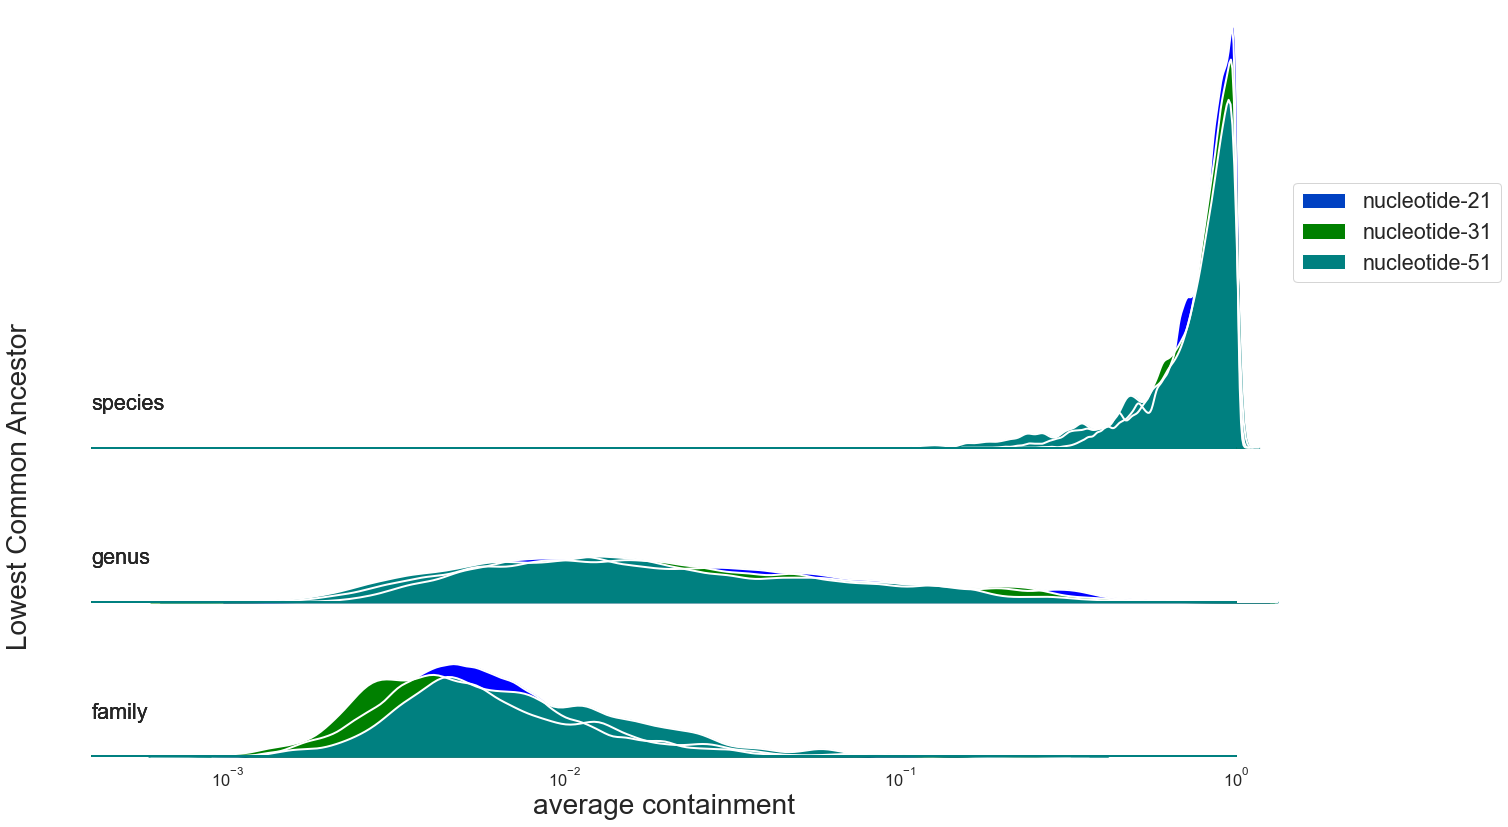

<Figure size 640x480 with 0 Axes>

In [17]:
def label(x, color, label):
        ax = plt.gca()
        lb = x.unique()[0]#.upper()
       # print(lb)
        ax.text(0, .1, lb, size="large",# fontweight="bold",# color=color,
                ha="left", va="center", transform=ax.transAxes)

#sns.set_theme(style="white")
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)

#with sns.plotting_context("paper", font_scale=2,rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15, "axes.facecolor": (0, 0, 0, 0)}):
#THIS PLOTTING CONTEXT screws things up for some reason.
g = sns.FacetGrid(sourmash_only, row="lca_rank", hue="method", aspect=15, height=1.2, palette=sourmash_colors)
g.set(xscale="log")

g.map(sns.kdeplot, "cov_or_containment", bw_adjust=.6, cut=5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "cov_or_containment", bw_adjust=.6, cut=5, clip_on=False, color="w", lw=2)
g.map(plt.axhline, y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
plt.gcf().set_size_inches(17, 12) 

    
g.map(label, "lca_rank")
    # make overlapping
#plt.subplots_adjust(hspace=-.65)
g.fig.subplots_adjust(hspace=-.65)

    # remove axis details that don't work well with overlapping plots
g.set(yticks=[], xlabel="", ylabel="", xlim=(None, 1),ylim=(None, None), title="")# xlim=(None, 1), , fontsize =10)
g.despine(bottom=True, left=True)

# create a legend
handles=[]
for ak, color in method_colors.items():
    if ak in sourmash_only["method"].unique():
        handles.append(mpatches.Patch(facecolor=color, label=ak))
lgd = plt.legend(handles=handles, bbox_to_anchor=(1.05, 1.3), loc=2, borderaxespad=0., facecolor="white", fontsize="large")
    
txt= g.fig.text(-0.02, 0.4, 'Lowest Common Ancestor', va='center', rotation='vertical', size=28)

plt.xlabel("average containment", size=28)
    #plt.ylabel("Lowest Common Ancestor", size=28)
plt.show()
plt.tight_layout()
#g.fig.savefig("gtdb-rs202.evolpaths.alphacompare.avgContain.logscale.ridgeplot.pdf", bbox_extra_artists=(lgd,txt), bbox_inches='tight')
#g.fig.savefig("gtdb-rs202.evolpaths.alphacompare.avgContain.logscale.ridgeplot.png", bbox_extra_artists=(lgd,txt), bbox_inches='tight')

In [19]:
k21 = sourmash_only[sourmash_only["method"] == "nucleotide-21"]

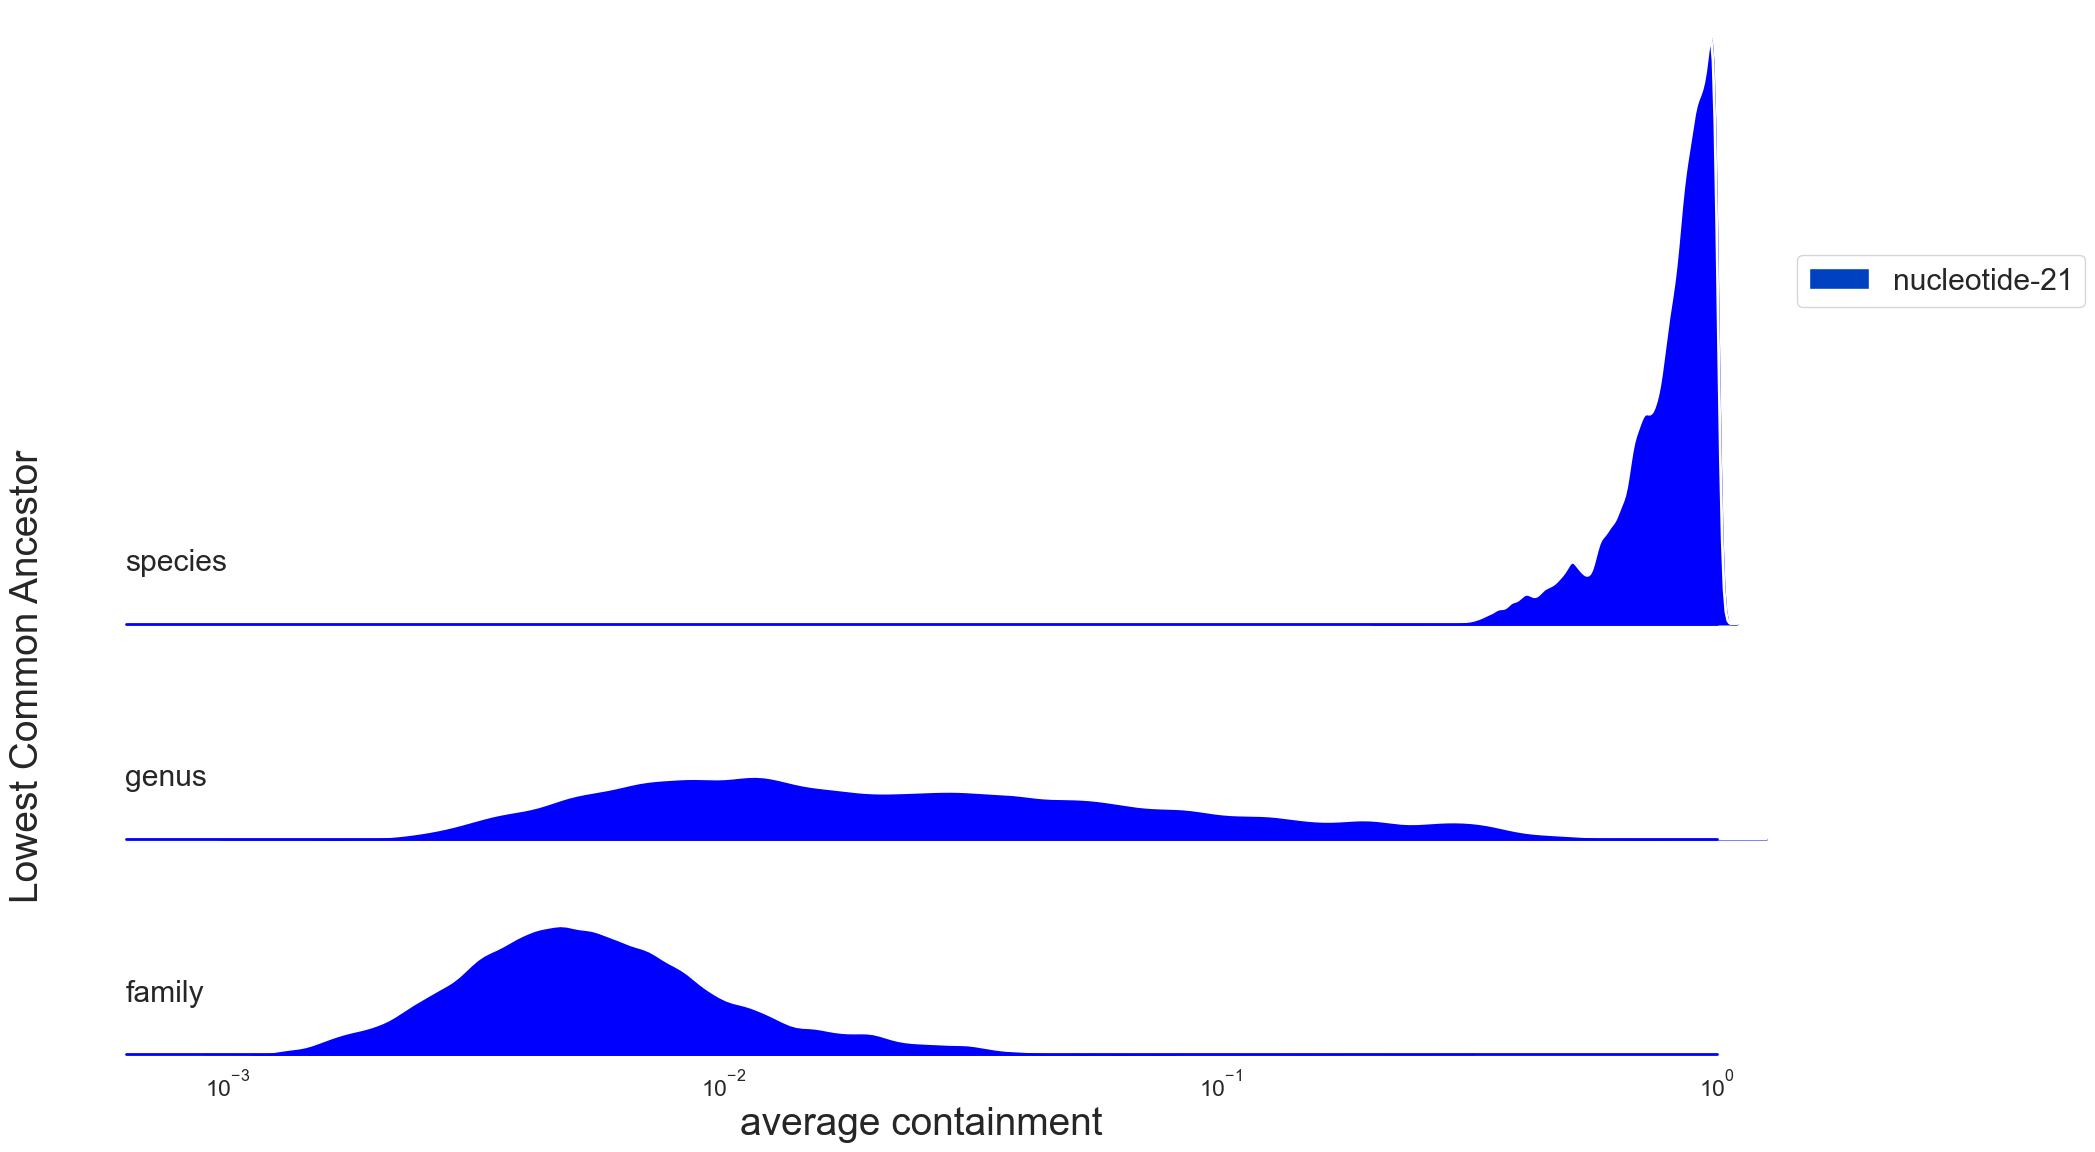

<Figure size 640x480 with 0 Axes>

In [23]:
def label(x, color, label):
        ax = plt.gca()
        lb = x.unique()[0]#.upper()
       # print(lb)
        ax.text(0, .1, lb, size="large",# fontweight="bold",# color=color,
                ha="left", va="center", transform=ax.transAxes)

#sns.set_theme(style="white")
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)

#with sns.plotting_context("paper", font_scale=2,rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15, "axes.facecolor": (0, 0, 0, 0)}):
#THIS PLOTTING CONTEXT screws things up for some reason.
g = sns.FacetGrid(k21, row="lca_rank", hue="method", aspect=15, height=1.2, palette=sourmash_colors)
g.set(xscale="log")

g.map(sns.kdeplot, "cov_or_containment", bw_adjust=.6, cut=5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "cov_or_containment", bw_adjust=.6, cut=5, clip_on=False, color="w", lw=2)
g.map(plt.axhline, y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
plt.gcf().set_size_inches(17, 12) 

    
g.map(label, "lca_rank")
    # make overlapping
#plt.subplots_adjust(hspace=-.65)
g.fig.subplots_adjust(hspace=-.65)

    # remove axis details that don't work well with overlapping plots
g.set(yticks=[], xlabel="", ylabel="", xlim=(None, 1),ylim=(None, None), title="")# xlim=(None, 1), , fontsize =10)
g.despine(bottom=True, left=True)

# create a legend
handles=[]
for ak, color in method_colors.items():
    if ak in k21["method"].unique():
        handles.append(mpatches.Patch(facecolor=color, label=ak))
lgd = plt.legend(handles=handles, bbox_to_anchor=(1.05, 1.3), loc=2, borderaxespad=0., facecolor="white", fontsize="large")
    
txt= g.fig.text(-0.02, 0.4, 'Lowest Common Ancestor', va='center', rotation='vertical', size=28)

plt.xlabel("average containment", size=28)
    #plt.ylabel("Lowest Common Ancestor", size=28)
plt.show()
plt.tight_layout()
#g.fig.savefig("gtdb-rs202.evolpaths.alphacompare.avgContain.logscale.ridgeplot.pdf", bbox_extra_artists=(lgd,txt), bbox_inches='tight')
#g.fig.savefig("gtdb-rs202.evolpaths.alphacompare.avgContain.logscale.ridgeplot.png", bbox_extra_artists=(lgd,txt), bbox_inches='tight')

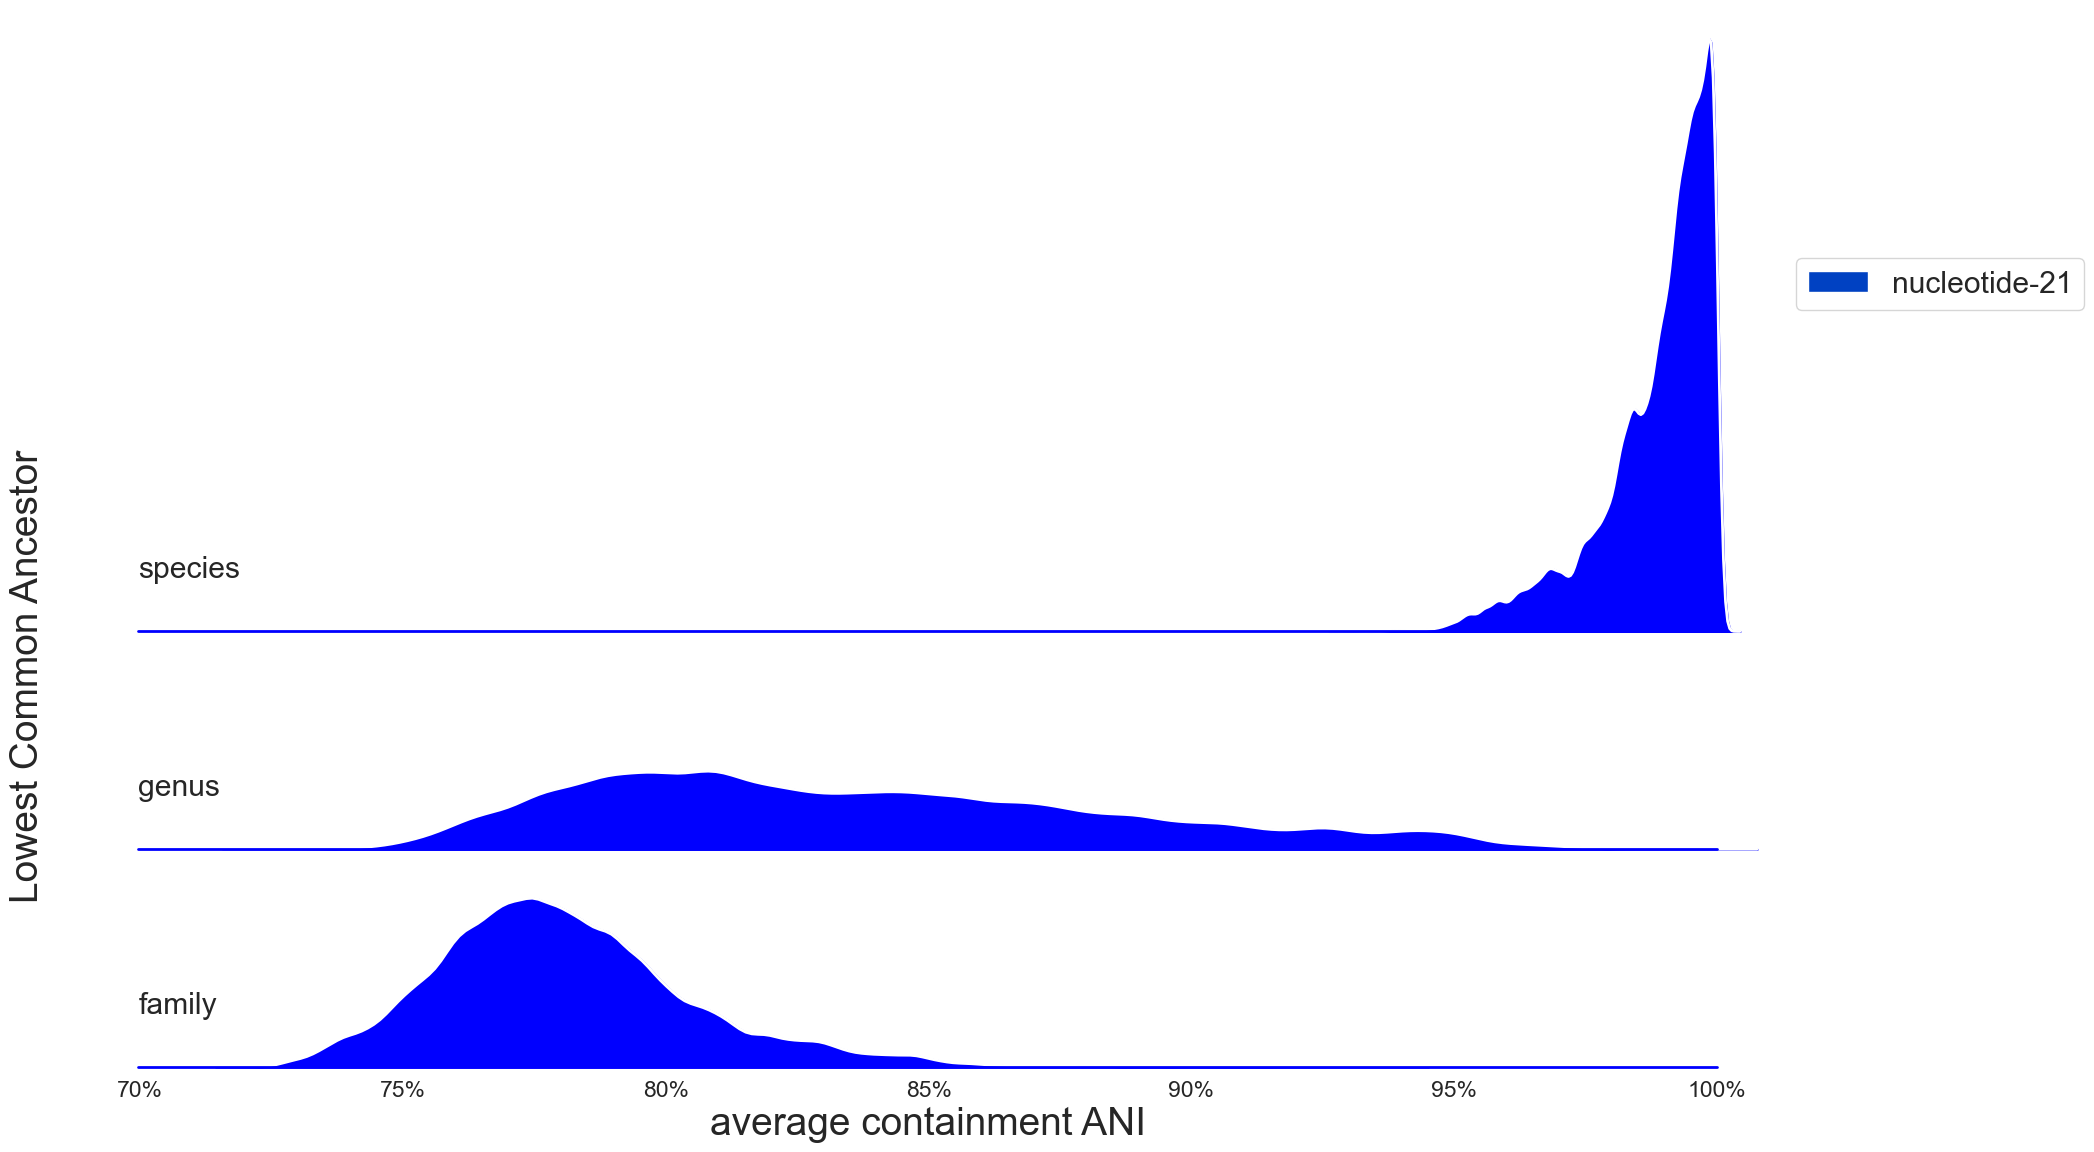

<Figure size 640x480 with 0 Axes>

In [26]:
def label(x, color, label):
        ax = plt.gca()
        lb = x.unique()[0]#.upper()
       # print(lb)
        ax.text(0, .1, lb, size="large",# fontweight="bold",# color=color,
                ha="left", va="center", transform=ax.transAxes)

#sns.set_theme(style="white")
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}, font_scale=1.5)

#with sns.plotting_context("paper", font_scale=2,rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15, "axes.facecolor": (0, 0, 0, 0)}):
#THIS PLOTTING CONTEXT screws things up for some reason.
g = sns.FacetGrid(k21, row="lca_rank", hue="method", aspect=15, height=1.2, palette=sourmash_colors)
#g.set(xscale="log")

g.map(sns.kdeplot, "ANI", bw_adjust=.6, cut=5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "ANI", bw_adjust=.6, cut=5, clip_on=False, color="w", lw=2)
g.map(plt.axhline, y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
plt.gcf().set_size_inches(17, 12) 

    
g.map(label, "lca_rank")
    # make overlapping
#plt.subplots_adjust(hspace=-.65)
g.fig.subplots_adjust(hspace=-.65)

    # remove axis details that don't work well with overlapping plots
g.set(yticks=[], xlabel="", ylabel="", xlim=(None, 1),ylim=(None, None), title="")# xlim=(None, 1), , fontsize =10)
g.despine(bottom=True, left=True)

# create a legend
handles=[]
for ak, color in method_colors.items():
    if ak in k21["method"].unique():
        handles.append(mpatches.Patch(facecolor=color, label=ak))
lgd = plt.legend(handles=handles, bbox_to_anchor=(1.05, 1.3), loc=2, borderaxespad=0., facecolor="white", fontsize="large")
    
txt= g.fig.text(-0.02, 0.4, 'Lowest Common Ancestor', va='center', rotation='vertical', size=28)
#g.ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
#    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))

g.axes.flat[0].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))


plt.xlabel("average containment ANI", size=28)
    #plt.ylabel("Lowest Common Ancestor", size=28)
plt.show()
plt.tight_layout()
#g.fig.savefig("gtdb-rs202.evolpaths.alphacompare.avgContain.logscale.ridgeplot.pdf", bbox_extra_artists=(lgd,txt), bbox_inches='tight')
#g.fig.savefig("gtdb-rs202.evolpaths.alphacompare.avgContain.logscale.ridgeplot.png", bbox_extra_artists=(lgd,txt), bbox_inches='tight')

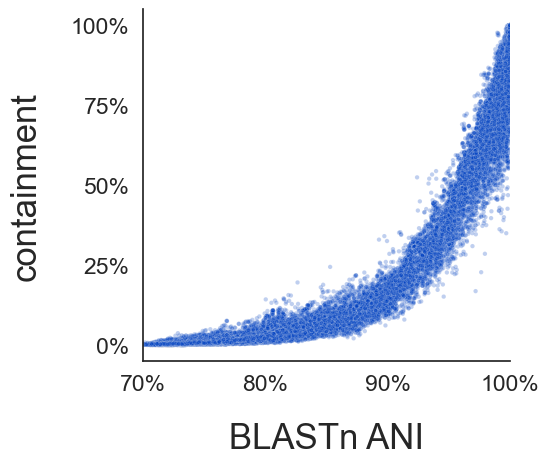

In [34]:
# plot containment -- ANIb
g = sns.relplot(data=k21, x = "ANIb", y="cov_or_containment",  hue="method",# col="method",
                alpha=0.25, s=10, palette=method_colors,
                height=5, legend=False,  aspect=7/6)
xlim = (0.7, 1)
g.set(xlim=xlim)#, ylim=xlim)
#g.set(xscale="log")

for ax in g.axes.flat:
    #ax.plot(xlim, xlim, ls="--",color="black") #c=".3"
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    
    #slope, intercept, r_value, p_value, std_err = sp.stats.linregress(k21["ANIb"],k21["ANI"])
    #r_value is pearson correlation coefficient
    #predict_y = slope * k21["ANIb"] + intercept
    # do we want R^2? if yes, get from sklearn r2_score using y_observed, y_predicted
    #r_squared = r2_score(k21["ANIb"], predict_y)
    #label = labelD[var] + " " + ak_labels[ak] #param_labels[n]
    label = "k21"
    method = "FracMinHash k21"
    #line_label = f'{method}\ny={slope:.4f}x+{intercept:.3f}\nR2={r_squared:.3f}\nr={r_value:.3f}'
    #ax.plot(k21["ANIb"], predict_y, color = method_colors["nucleotide-21"], label = line_label, linewidth=2)
    #ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),fancybox=True, shadow=True, prop={"size":15}, facecolor="white")
    
    ax.set_ylabel("containment", size=25, labelpad=20)
    ax.set_xlabel("BLASTn ANI", size=25, labelpad=20)

    
g.fig.tight_layout()
#g.fig.savefig("gtdb-rs207.family200.cANI-vs-ANIb.k21.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
#g.fig.savefig("gtdb-rs207.family200.cANI-vs-ANIb.k21.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

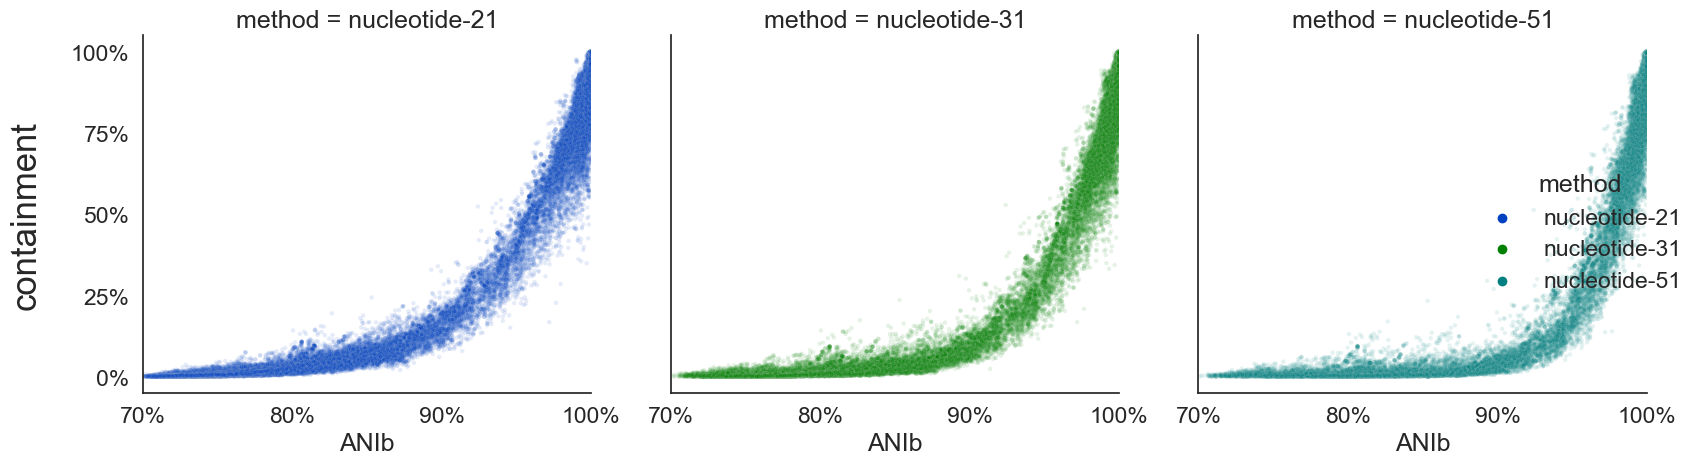

In [44]:
g = sns.relplot(data=ani[~ani["method"].isin(["pyani_anim", "pyani_anib", "FastANI"])], 
                x = "ANIb", y="cov_or_containment", col="method", hue="method",# sharey=False, 
                alpha=0.1, s=10, palette=method_colors)
xlim = (0.7, 1)
g.set(xlim=xlim)#, ylim=xlim)
for ax in g.axes.flat:
    #ax.plot(xlim, xlim, ls="--",color="black") #c=".3"
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.25))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    ax.set_ylabel("containment", size=25, labelpad=20)
g.fig.tight_layout()

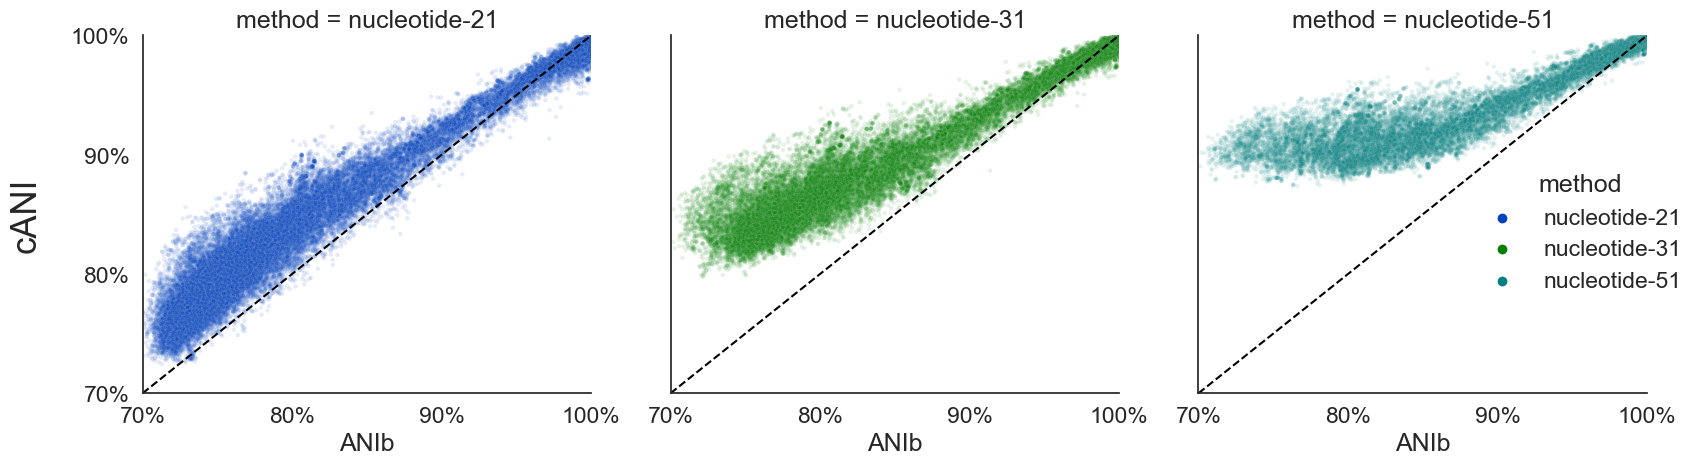

In [47]:
g = sns.relplot(data=ani[~ani["method"].isin(["pyani_anim", "pyani_anib", "FastANI"])], 
                x = "ANIb", y="ANI", col="method", hue="method",# sharey=False, 
                alpha=0.1, s=10, palette=method_colors)
xlim = (0.7, 1)
g.set(xlim=xlim, ylim=xlim)
for ax in g.axes.flat:
    ax.plot(xlim, xlim, ls="--",color="black") #c=".3"
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    ax.set_ylabel("cANI", size=25, labelpad=20)
g.fig.tight_layout()

# Compare ANIb vs cANI

In [18]:
ani.tail()

comparison_name lca_rank  lca_lineage      ANIb  \
720601  GCA_016187745_x_GCA_018304445    genus  g__JACPJC01  0.875225   
720602  GCA_011334735_x_GCA_014361295    genus  g__JACIVX01  0.883671   
720603  GCA_019058315_x_GCA_013375355    genus  g__JABXJV01  0.846342   
720604  GCA_018302805_x_GCA_018302785    genus  g__JAGVZF01  0.751491   
720605  GCA_013331595_x_GCA_018304285    genus  g__UBA10210  0.745205   

        ANIb_cov         method       ANI  cov_or_containment  
720601  0.498841  nucleotide-51  0.920882            0.015235  
720602  0.730546  nucleotide-51  0.913603            0.010127  
720603  0.525580  nucleotide-51  0.887925            0.002349  
720604  0.356937  nucleotide-51  0.916807            0.011930  
720605  0.202488  nucleotide-51  0.930169            0.025807

In [19]:
ani[ani["method"] == "pyani_anim"]

comparison_name lca_rank  \
233837  GCF_002252245_x_GCF_018415725  species   
233838  GCF_002252245_x_GCF_018415905  species   
233839  GCF_002252245_x_GCF_018415875  species   
233840  GCF_002252245_x_GCF_002252325  species   
233841  GCF_002252245_x_GCF_018415665  species   
...                               ...      ...   
467669  GCA_013138805_x_GCA_013138765    genus   
467670  GCA_007118975_x_GCA_007123105    genus   
467671  GCA_013388925_x_GCA_011358735    genus   
467672  GCA_017608505_x_GCA_014729335   family   
467673  GCA_018304245_x_GCA_002499185    genus   

                                lca_lineage      ANIb  ANIb_cov      method  \
233837  s__Wohlfahrtiimonas chitiniclastica  0.980896  0.905852  pyani_anim   
233838  s__Wohlfahrtiimonas chitiniclastica  0.981019  0.910210  pyani_anim   
233839  s__Wohlfahrtiimonas chitiniclastica  0.979370  0.894288  pyani_anim   
233840  s__Wohlfahrtiimonas chitiniclastica  0.980128  0.916761  pyani_anim   
233841  s__Wohlfahrtiimonas chitiniclastica  0.980726  0.931576  pyani_anim   
...                                     ...       ...       ...         ...   
467669                             g__GLR71  0.734772  0.318503  pyani_anim   
467670                            g__SKNY01  0.722232  0.161302  pyani_anim   
467671                          g__JACAEJ01  0.748033  0.462275  pyani_anim   
467672                            f__WJKC01  0.678123  0.047254  pyani_anim   
467673                            g__UBA284  0.740753  0.272192  pyani_anim   

             ANI  cov_or_containment  
233837  0.981945            0.917084  
233838  0.982615            0.917138  
233839  0.981910            0.898994  
233840  0.982011            0.925954  
233841  0.982144            0.940488  
...          ...                 ...  
467669  0.855032            0.017839  
467670  0.843243            0.010669  
467671  0.835801            0.042703  
467672  0.855634            0.003871  
467673  0.825036            0.038861  

[233837 rows x 8 columns]

In [20]:
ani[ani["comparison_name"] == "GCA_013388925_x_GCA_011358735"]

comparison_name lca_rank  lca_lineage      ANIb  \
233834  GCA_013388925_x_GCA_011358735    genus  g__JACAEJ01  0.748033   
467671  GCA_013388925_x_GCA_011358735    genus  g__JACAEJ01  0.748033   
549418  GCA_013388925_x_GCA_011358735    genus  g__JACAEJ01  0.748033   

        ANIb_cov      method       ANI  cov_or_containment  
233834  0.462275  pyani_anib  0.748033            0.462275  
467671  0.462275  pyani_anim  0.835801            0.042703  
549418  0.462275     FastANI  0.772440            0.212286

In [21]:
methods = ani.method.unique()
methods

array(['pyani_anib', 'pyani_anim', 'FastANI', 'nucleotide-21',
       'nucleotide-31', 'nucleotide-51'], dtype=object)

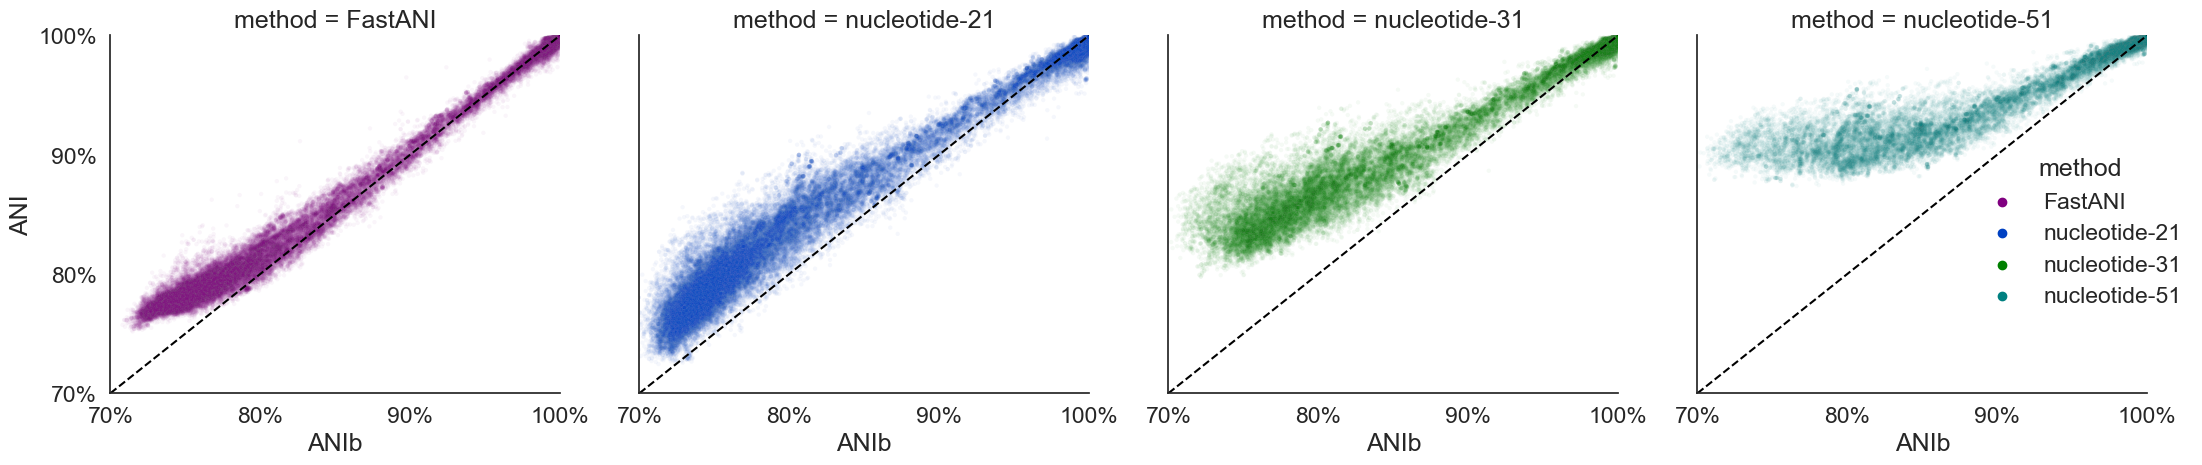

In [22]:
g = sns.relplot(data=ani[~ani["method"].isin(["pyani_anim", "pyani_anib"])], 
                x = "ANIb", y="ANI", col="method", hue="method",# sharey=False, 
                alpha=0.04, s=10, palette=method_colors)
xlim = (0.7, 1)
g.set(xlim=xlim, ylim=xlim)
for ax in g.axes.flat:
    ax.plot(xlim, xlim, ls="--",color="black") #c=".3"
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
g.fig.tight_layout()

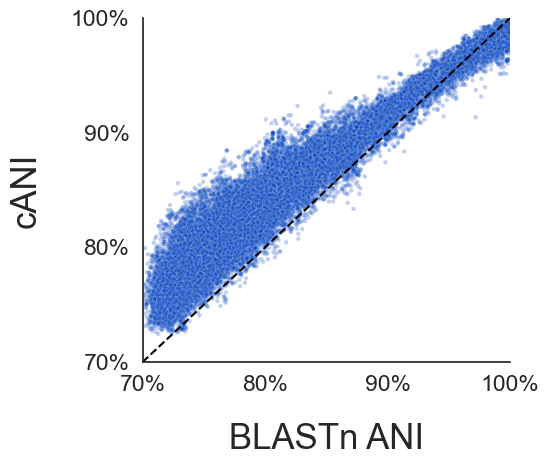

In [24]:
#PLOT JUST K21
# ani[~ani["method"].isin(["pyani_anim", "pyani_anib", "FastANI", "nucleotide-31", "nucleotide-51"])]
k21 = ani[ani["method"] == "nucleotide-21"]
g = sns.relplot(data=k21, x = "ANIb", y="ANI",  hue="method",# col="method",
                alpha=0.25, s=10, palette=method_colors,
                height=5, legend=False,  aspect=7/6)
xlim = (0.7, 1)
g.set(xlim=xlim, ylim=xlim)
for ax in g.axes.flat:
    ax.plot(xlim, xlim, ls="--",color="black") #c=".3"
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(k21["ANIb"],k21["ANI"])
    #r_value is pearson correlation coefficient
    predict_y = slope * k21["ANIb"] + intercept
    # do we want R^2? if yes, get from sklearn r2_score using y_observed, y_predicted
    r_squared = r2_score(k21["ANIb"], predict_y)
    #label = labelD[var] + " " + ak_labels[ak] #param_labels[n]
    label = "k21"
    method = "FracMinHash k21"
    line_label = f'{method}\ny={slope:.4f}x+{intercept:.3f}\nR2={r_squared:.3f}\nr={r_value:.3f}'
    #ax.plot(k21["ANIb"], predict_y, color = method_colors["nucleotide-21"], label = line_label, linewidth=2)
    #ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),fancybox=True, shadow=True, prop={"size":15}, facecolor="white")
    
    ax.set_ylabel("cANI", size=25, labelpad=20)
    ax.set_xlabel("BLASTn ANI", size=25, labelpad=20)

    
g.fig.tight_layout()
#g.fig.savefig("gtdb-rs207.family200.cANI-vs-ANIb.k21.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
#g.fig.savefig("gtdb-rs207.family200.cANI-vs-ANIb.k21.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

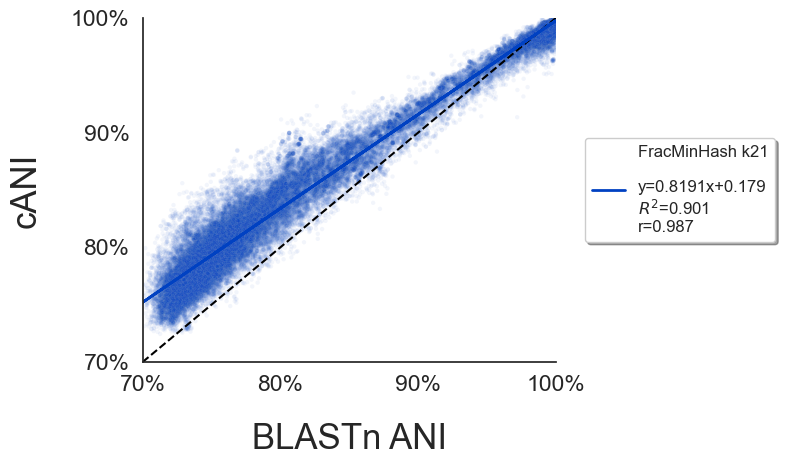

In [49]:
#PLOT JUST K21
# ani[~ani["method"].isin(["pyani_anim", "pyani_anib", "FastANI", "nucleotide-31", "nucleotide-51"])]
k21 = ani[ani["method"] == "nucleotide-21"]
g = sns.relplot(data=k21, x = "ANIb", y="ANI",  hue="method",# col="method",# sharey=False, 
                alpha=0.05, s=10, palette=method_colors,
                height=5, legend=False,  aspect=10/6)
xlim = (0.7, 1)
g.set(xlim=xlim, ylim=xlim)
for ax in g.axes.flat:
    ax.plot(xlim, xlim, ls="--",color="black") #c=".3"
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(k21["ANIb"],k21["ANI"])
    #r_value is pearson correlation coefficient
    predict_y = slope * k21["ANIb"] + intercept
    # do we want R^2? if yes, get from sklearn r2_score using y_observed, y_predicted
    r_squared = r2_score(k21["ANIb"], predict_y)
    #label = labelD[var] + " " + ak_labels[ak] #param_labels[n]
    label = "k21"
    method = "FracMinHash k21"
    line_label = f'{method}\n\ny={slope:.4f}x+{intercept:.3f}\n$R^{2}$={r_squared:.3f}\nr={r_value:.3f}'
    ax.plot(k21["ANIb"], predict_y, color = method_colors["nucleotide-21"], label = line_label, linewidth=2)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),fancybox=True, shadow=True, prop={"size":12}, facecolor="white")
    
    ax.set_ylabel("cANI", size=25, labelpad=20)
    ax.set_xlabel("BLASTn ANI", size=25, labelpad=20)

    
g.fig.tight_layout()
g.fig.savefig("gtdb-rs207.family200.cANI-vs-ANIb.k21.line.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
g.fig.savefig("gtdb-rs207.family200.cANI-vs-ANIb.k21.line.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

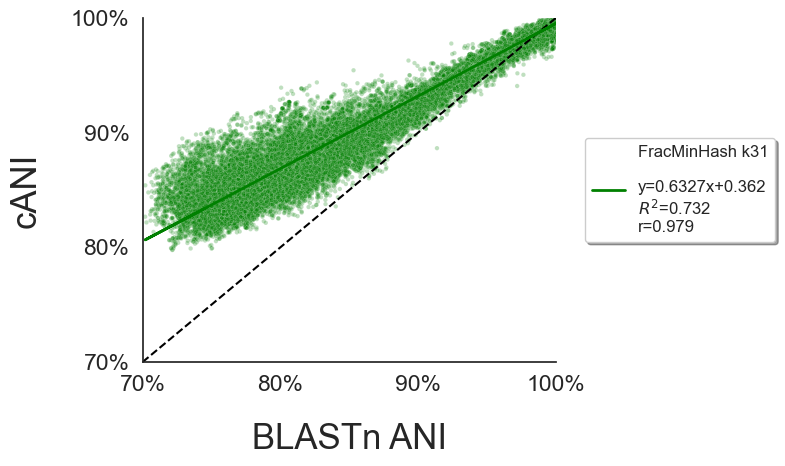

In [30]:
#PLOT JUST K21
# ani[~ani["method"].isin(["pyani_anim", "pyani_anib", "FastANI", "nucleotide-31", "nucleotide-51"])]
k31 = ani[ani["method"] == "nucleotide-31"]
g = sns.relplot(data=k31, x = "ANIb", y="ANI",  hue="method",# col="method",# sharey=False, 
                alpha=0.25, s=10, palette=method_colors,
                height=5, legend=False,  aspect=10/6)
xlim = (0.7, 1)
g.set(xlim=xlim, ylim=xlim)
for ax in g.axes.flat:
    ax.plot(xlim, xlim, ls="--",color="black") #c=".3"
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(k31["ANIb"],k31["ANI"])
    #r_value is pearson correlation coefficient
    predict_y = slope * k31["ANIb"] + intercept
    # do we want R^2? if yes, get from sklearn r2_score using y_observed, y_predicted
    r_squared = r2_score(k31["ANIb"], predict_y)
    #label = labelD[var] + " " + ak_labels[ak] #param_labels[n]
    label = "k31"
    method = "FracMinHash k31"
    line_label = f'{method}\n\ny={slope:.4f}x+{intercept:.3f}\n$R^{2}$={r_squared:.3f}\nr={r_value:.3f}'
    ax.plot(k31["ANIb"], predict_y, color = method_colors["nucleotide-31"], label = line_label, linewidth=2)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),fancybox=True, shadow=True, prop={"size":12}, facecolor="white")
    
    ax.set_ylabel("cANI", size=25, labelpad=20)
    ax.set_xlabel("BLASTn ANI", size=25, labelpad=20)

    
g.fig.tight_layout()
g.fig.savefig("gtdb-rs207.family200.cANI-vs-ANIb.k31.line.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
g.fig.savefig("gtdb-rs207.family200.cANI-vs-ANIb.k31.line.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

In [26]:
ani[(ani["method"] == "nucleotide-51") & (ani['ANIb'] > .999)]

comparison_name lca_rank  \
680494  GCF_018415875_x_GCF_018415865  species   
680573  GCF_002252265_x_GCF_002252255  species   
680618  GCF_018415765_x_GCF_018415645  species   
680622  GCF_018415765_x_GCF_018415635  species   
680623  GCF_018415765_x_GCF_018415785  species   
...                               ...      ...   
720522  GCA_018302365_x_GCA_000830315  species   
720559  GCA_001856825_x_GCA_009387875  species   
720560  GCA_011366705_x_GCA_011364745  species   
720563  GCA_018661765_x_GCA_018698915  species   
720579  GCF_000017945_x_GCA_013329705  species   

                                lca_lineage      ANIb  ANIb_cov  \
680494  s__Wohlfahrtiimonas chitiniclastica  0.999954  0.998730   
680573  s__Wohlfahrtiimonas chitiniclastica  0.999999  0.998252   
680618  s__Wohlfahrtiimonas chitiniclastica  0.999814  0.999346   
680622  s__Wohlfahrtiimonas chitiniclastica  0.999867  0.998868   
680623  s__Wohlfahrtiimonas chitiniclastica  0.999880  0.999606   
...                                     ...       ...       ...   
720522           s__GW2011-AR20 sp000830315  0.999187  0.991232   
720559         s__GCA-001856825 sp001856825  0.999827  0.997881   
720560                s__DTBS01 sp011366705  0.999899  0.992450   
720563              s__JAAZWY01 sp018698915  0.999522  0.890555   
720579           s__Ignicoccus_A hospitalis  0.999373  0.986499   

               method       ANI  cov_or_containment  
680494  nucleotide-51  0.999991            0.999544  
680573  nucleotide-51  0.999977            0.998823  
680618  nucleotide-51  0.999991            0.999537  
680622  nucleotide-51  0.999995            0.999769  
680623  nucleotide-51  0.999986            0.999306  
...               ...       ...                 ...  
720522  nucleotide-51  0.999915            0.995664  
720559  nucleotide-51  0.999976            0.998795  
720560  nucleotide-51  0.999923            0.996097  
720563  nucleotide-51  0.997924            0.900860  
720579  nucleotide-51  0.999901            0.994953  

[4606 rows x 8 columns]

In [27]:
ani[(ani["method"] == "nucleotide-51") & (ani['ANIb'] > .95)]

comparison_name lca_rank  \
680402  GCF_002252245_x_GCF_018415875  species   
680403  GCF_002252245_x_GCF_002252225  species   
680405  GCF_002252245_x_GCF_018415665  species   
680406  GCF_002252245_x_GCF_018415645  species   
680407  GCF_002252245_x_GCF_018415725  species   
...                               ...      ...   
720573  GCA_002779595_x_GCA_002779795  species   
720574  GCA_016839295_x_GCA_011364965  species   
720577  GCA_018816395_x_GCA_018816585  species   
720578  GCA_013415715_x_GCA_013415695  species   
720579  GCF_000017945_x_GCA_013329705  species   

                                lca_lineage      ANIb  ANIb_cov  \
680402  s__Wohlfahrtiimonas chitiniclastica  0.979370  0.894288   
680403  s__Wohlfahrtiimonas chitiniclastica  0.981375  0.906950   
680405  s__Wohlfahrtiimonas chitiniclastica  0.980726  0.931576   
680406  s__Wohlfahrtiimonas chitiniclastica  0.980923  0.913148   
680407  s__Wohlfahrtiimonas chitiniclastica  0.980896  0.905852   
...                                     ...       ...       ...   
720573             s__CG07-land sp002779595  0.997981  0.811911   
720574           s__Hodarchaeum sp011364965  0.998486  0.816063   
720577              s__JAHIVQ01 sp018816585  0.997170  0.800225   
720578              s__JAAEEP01 sp013415695  0.997489  0.948663   
720579           s__Ignicoccus_A hospitalis  0.999373  0.986499   

               method       ANI  cov_or_containment  
680402  nucleotide-51  0.985658            0.478670  
680403  nucleotide-51  0.986564            0.501719  
680405  nucleotide-51  0.987064            0.514828  
680406  nucleotide-51  0.986330            0.495614  
680407  nucleotide-51  0.986425            0.498083  
...               ...       ...                 ...  
720573  nucleotide-51  0.996546            0.838360  
720574  nucleotide-51  0.995164            0.789126  
720577  nucleotide-51  0.995382            0.793457  
720578  nucleotide-51  0.998552            0.929016  
720579  nucleotide-51  0.999901            0.994953  

[22541 rows x 8 columns]

In [28]:
ani

comparison_name lca_rank  \
0       GCF_002252245_x_GCF_018415725  species   
1       GCF_002252245_x_GCF_018415905  species   
2       GCF_002252245_x_GCF_018415875  species   
3       GCF_002252245_x_GCF_002252325  species   
4       GCF_002252245_x_GCF_018415665  species   
...                               ...      ...   
720601  GCA_016187745_x_GCA_018304445    genus   
720602  GCA_011334735_x_GCA_014361295    genus   
720603  GCA_019058315_x_GCA_013375355    genus   
720604  GCA_018302805_x_GCA_018302785    genus   
720605  GCA_013331595_x_GCA_018304285    genus   

                                lca_lineage      ANIb  ANIb_cov  \
0       s__Wohlfahrtiimonas chitiniclastica  0.980896  0.905852   
1       s__Wohlfahrtiimonas chitiniclastica  0.981019  0.910210   
2       s__Wohlfahrtiimonas chitiniclastica  0.979370  0.894288   
3       s__Wohlfahrtiimonas chitiniclastica  0.980128  0.916761   
4       s__Wohlfahrtiimonas chitiniclastica  0.980726  0.931576   
...                                     ...       ...       ...   
720601                          g__JACPJC01  0.875225  0.498841   
720602                          g__JACIVX01  0.883671  0.730546   
720603                          g__JABXJV01  0.846342  0.525580   
720604                          g__JAGVZF01  0.751491  0.356937   
720605                          g__UBA10210  0.745205  0.202488   

               method       ANI  cov_or_containment  
0          pyani_anib  0.980896            0.905852  
1          pyani_anib  0.981019            0.910210  
2          pyani_anib  0.979370            0.894288  
3          pyani_anib  0.980128            0.916761  
4          pyani_anib  0.980726            0.931576  
...               ...       ...                 ...  
720601  nucleotide-51  0.920882            0.015235  
720602  nucleotide-51  0.913603            0.010127  
720603  nucleotide-51  0.887925            0.002349  
720604  nucleotide-51  0.916807            0.011930  
720605  nucleotide-51  0.930169            0.025807  

[720606 rows x 8 columns]

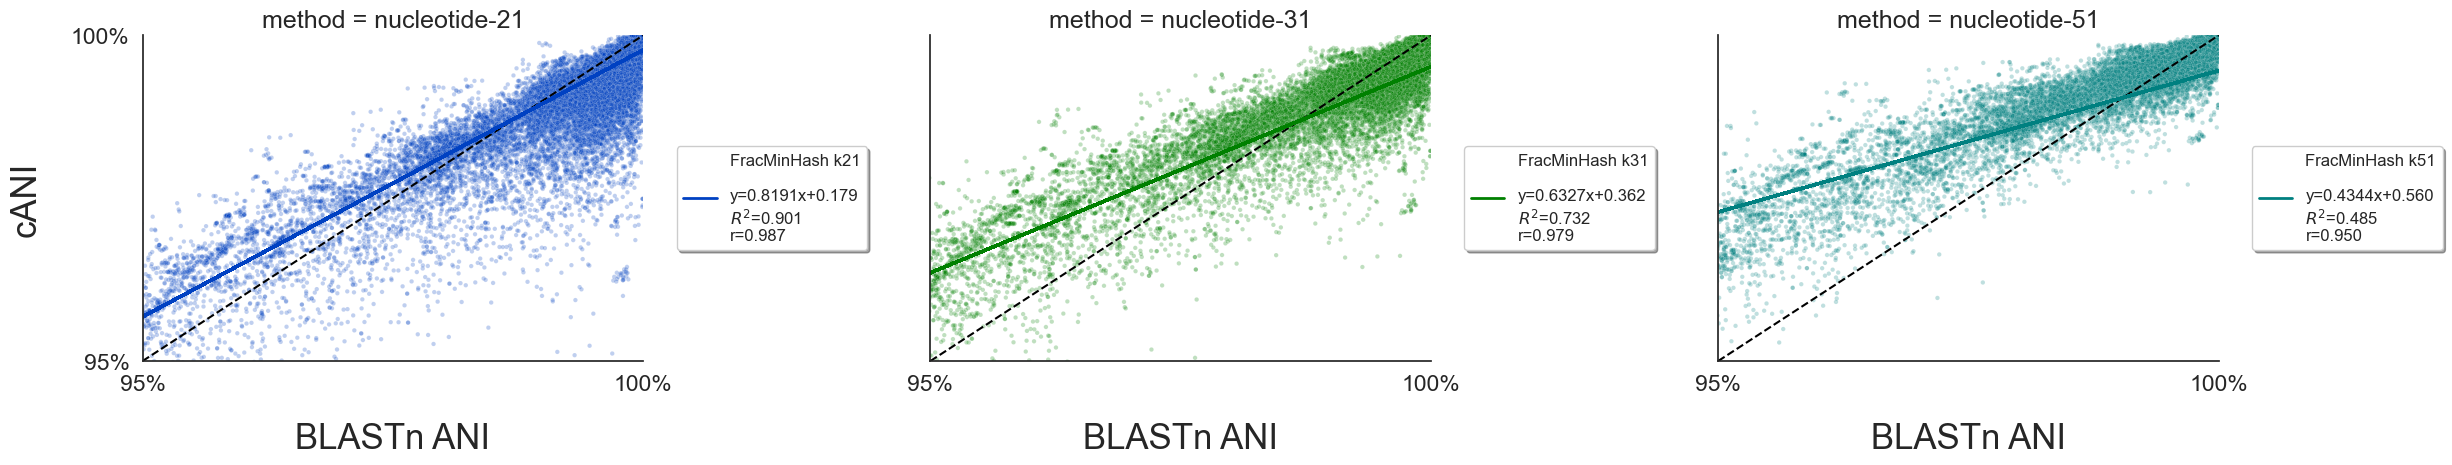

In [29]:
smash_a = ani[~ani["method"].isin(["pyani_anim", "pyani_anib", "FastANI"])] #, "nucleotide-31", "nucleotide-51"])]
#k21 = ani[ani["method"] == "nucleotide-21"]
g = sns.relplot(data=smash_a, x = "ANIb", y="ANI",  hue="method", col="method",# sharey=False, 
                alpha=0.25, s=10, palette=method_colors,
                height=5, legend=False,  aspect=10/6)
xlim = (0.95, 1)
g.set(xlim=xlim, ylim=xlim)
ls = ["nucleotide-21", "nucleotide-31", "nucleotide-51"]
for n, ax in enumerate(g.axes.flat):
    ksize = ls[n]
    label = ksize.split('-')[1]
    df = smash_a[smash_a["method"]== ksize]
    ax.plot(xlim, xlim, ls="--",color="black") #c=".3"
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(df["ANIb"],df["ANI"])
    #r_value is pearson correlation coefficient
    predict_y = slope * df["ANIb"] + intercept
    # do we want R^2? if yes, get from sklearn r2_score using y_observed, y_predicted
    r_squared = r2_score(df["ANIb"], predict_y)
    #label = labelD[var] + " " + ak_labels[ak] #param_labels[n]
    #label = "ksize"
    method = f"FracMinHash k{label}"
    line_label = f'{method}\n\ny={slope:.4f}x+{intercept:.3f}\n$R^{2}$={r_squared:.3f}\nr={r_value:.3f}'
    ax.plot(df["ANIb"], predict_y, color = method_colors[ksize], label = line_label, linewidth=2)
    lgd = ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),fancybox=True, shadow=True, prop={"size":12}, facecolor="white")
    
    ax.set_ylabel("cANI", size=25, labelpad=20)
    ax.set_xlabel("BLASTn ANI", size=25, labelpad=20)

    
g.fig.tight_layout()
g.fig.savefig("gtdb-rs207.family200.cANI-vs-ANIb.95+.line.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
g.fig.savefig("gtdb-rs207.family200.cANI-vs-ANIb.95+.line.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

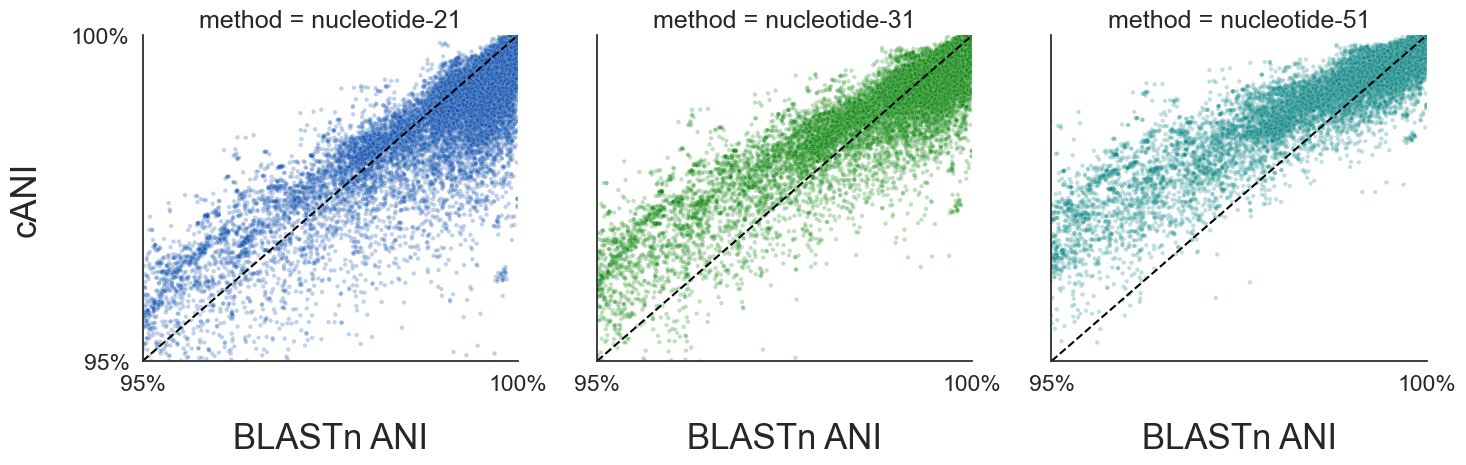

In [31]:
# update colors
method_colors = {'pyani_anib': "red", 'pyani_anim': "orange", 
                 'FastANI': "purple", 'nucleotide-21': "#0047ab", #"#C7313D", #"blue",
                 'nucleotide-31': "green", "nucleotide-51": "teal"}

smash_a = ani[~ani["method"].isin(["pyani_anim", "pyani_anib", "FastANI"])] #, "nucleotide-31", "nucleotide-51"])]
#k21 = ani[ani["method"] == "nucleotide-21"]
g = sns.relplot(data=smash_a, x = "ANIb", y="ANI",  hue="method", col="method",# sharey=False, 
                alpha=0.25, s=10, palette=method_colors,
                height=5, legend=False,  aspect=6/6)
xlim = (0.95, 1)
g.set(xlim=xlim, ylim=xlim)
ls = ["nucleotide-21", "nucleotide-31", "nucleotide-51"]
for n, ax in enumerate(g.axes.flat):
    ksize = ls[n]
    label = ksize.split('-')[1]
    df = smash_a[smash_a["method"]== ksize]
    ax.plot(xlim, xlim, ls="--",color="black") #c=".3"
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.05))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.05))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    
    #slope, intercept, r_value, p_value, std_err = sp.stats.linregress(df["ANIb"],df["ANI"])
    #r_value is pearson correlation coefficient
    #predict_y = slope * df["ANIb"] + intercept
    # do we want R^2? if yes, get from sklearn r2_score using y_observed, y_predicted
    #r_squared = r2_score(df["ANIb"], predict_y)
    #label = labelD[var] + " " + ak_labels[ak] #param_labels[n]
    #label = "ksize"
    #method = f"FracMinHash k{label}"
    #line_label = f'{method}\n\ny={slope:.4f}x+{intercept:.3f}\n$R^{2}$={r_squared:.3f}\nr={r_value:.3f}'
    #ax.plot(df["ANIb"], predict_y, color = method_colors[ksize], label = line_label, linewidth=2)
    #lgd = ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),fancybox=True, shadow=True, prop={"size":12}, facecolor="white")
    
    ax.set_ylabel("cANI", size=25, labelpad=20)
    ax.set_xlabel("BLASTn ANI", size=25, labelpad=20)

    
g.fig.tight_layout()
g.fig.savefig("gtdb-rs207.family200.cANI-vs-ANIb.95+.pdf",  bbox_inches='tight')
g.fig.savefig("gtdb-rs207.family200.cANI-vs-ANIb.95+.png", bbox_inches='tight')

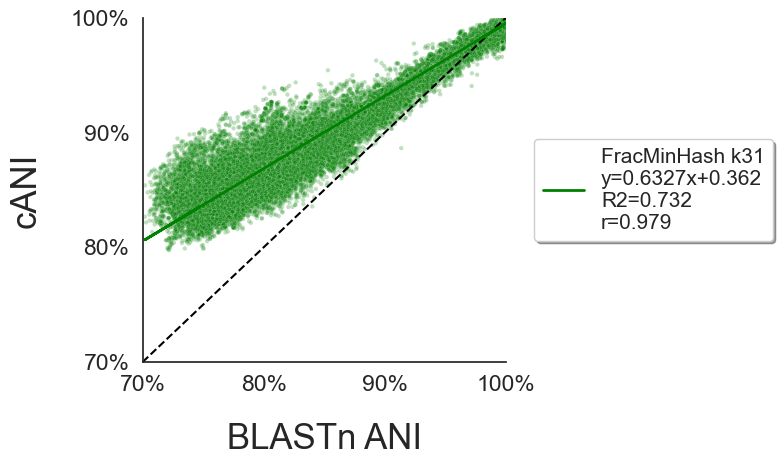

In [32]:
#PLOT JUST K31
# ani[~ani["method"].isin(["pyani_anim", "pyani_anib", "FastANI", "nucleotide-31", "nucleotide-51"])]
k31 = ani[ani["method"] == "nucleotide-31"]
g = sns.relplot(data=k31, x = "ANIb", y="ANI",  hue="method",# col="method",# sharey=False, 
                alpha=0.25, s=10, palette=method_colors,
                height=5, legend=False,  aspect=10/6)
xlim = (0.7, 1)
g.set(xlim=xlim, ylim=xlim)
for ax in g.axes.flat:
    ax.plot(xlim, xlim, ls="--",color="black") #c=".3"
    ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1,decimals=0))
    
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(k31["ANIb"],k31["ANI"])
    #r_value is pearson correlation coefficient
    predict_y = slope * k31["ANIb"] + intercept
    # do we want R^2? if yes, get from sklearn r2_score using y_observed, y_predicted
    r_squared = r2_score(k31["ANIb"], predict_y)
    #label = labelD[var] + " " + ak_labels[ak] #param_labels[n]
    label = "k31"
    method = "FracMinHash k31"
    line_label = f'{method}\ny={slope:.4f}x+{intercept:.3f}\nR2={r_squared:.3f}\nr={r_value:.3f}'
    ax.plot(k31["ANIb"], predict_y, color = method_colors["nucleotide-31"], label = line_label, linewidth=2)
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),fancybox=True, shadow=True, prop={"size":15}, facecolor="white")
    
    ax.set_ylabel("cANI", size=25, labelpad=20)
    ax.set_xlabel("BLASTn ANI", size=25, labelpad=20)

    
g.fig.tight_layout()
g.fig.savefig("gtdb-rs207.family200.cANI-vs-ANIb.k31.line.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')
g.fig.savefig("gtdb-rs207.family200.cANI-vs-ANIb.k31.line.png", bbox_extra_artists=(lgd,), bbox_inches='tight')

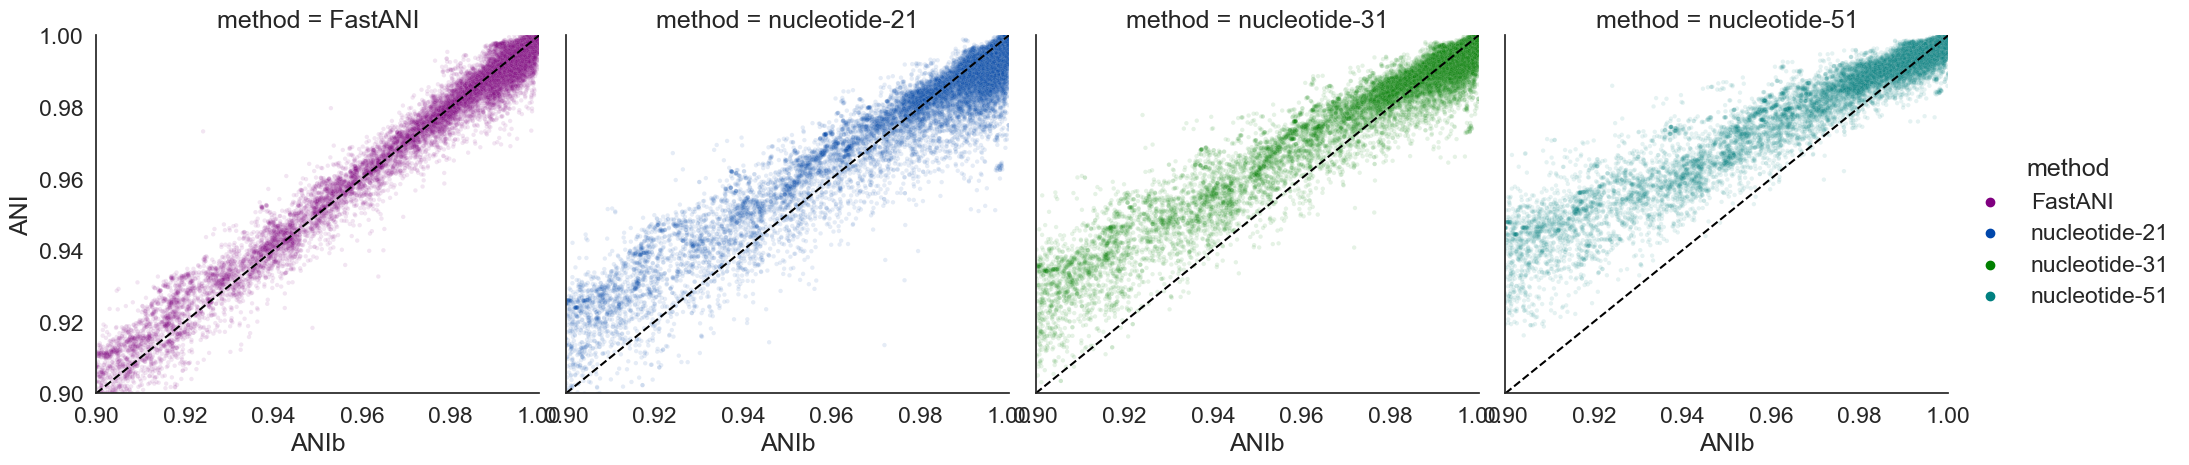

In [33]:
g = sns.relplot(data=ani[~ani["method"].isin(["pyani_anim", "pyani_anib"])], x = "ANIb", y="ANI", col="method", hue="method", alpha=0.1, s=10, palette=method_colors)
xlim = (0.9, 1)
g.set(xlim=xlim, ylim=xlim)
for ax in g.axes.flat:
    ax.plot(xlim, xlim, ls="--",color="black") #c=".3"

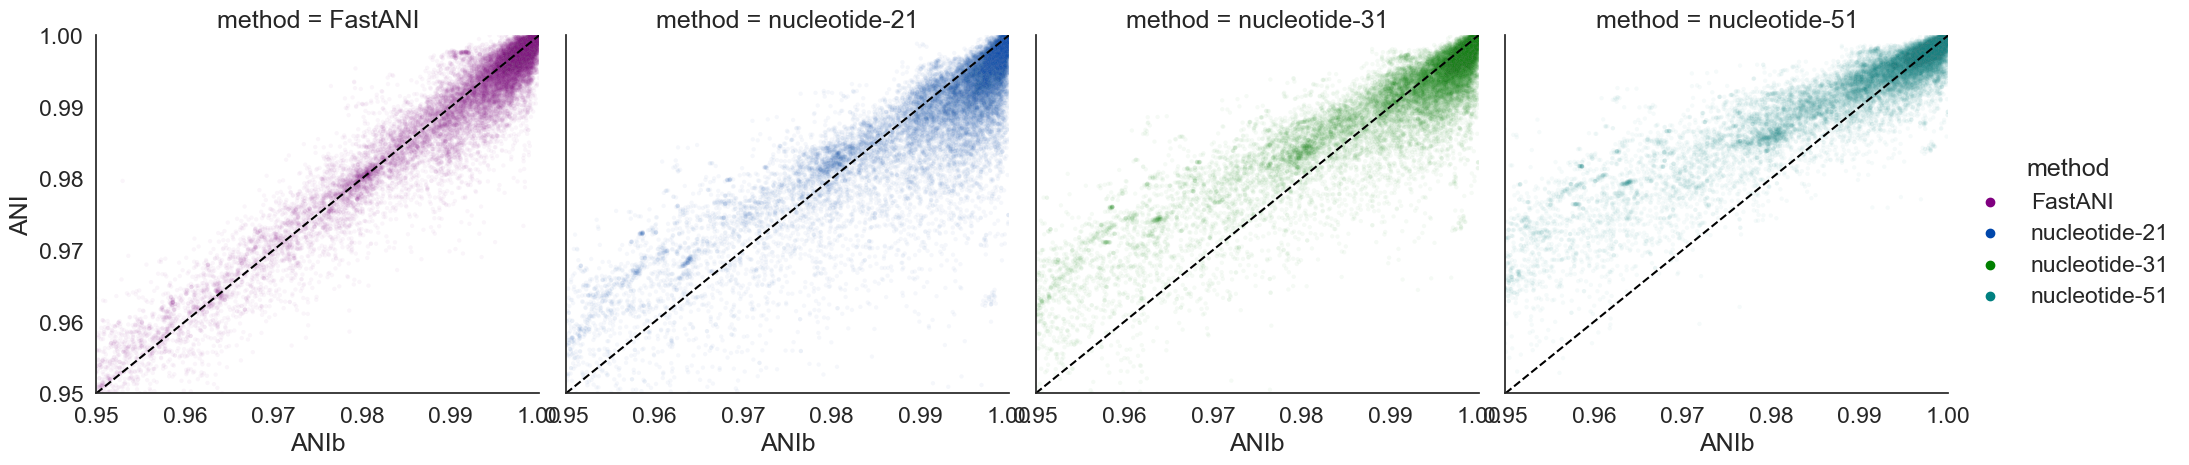

In [34]:
g = sns.relplot(data=ani[~ani["method"].isin(["pyani_anim", "pyani_anib"])], x = "ANIb", y="ANI", col="method", hue="method", alpha=0.04, s=10, palette=method_colors)
xlim = (0.95, 1)
g.set(xlim=xlim, ylim=xlim)
for ax in g.axes.flat:
    ax.plot(xlim, xlim, ls="--",color="black") #c=".3"

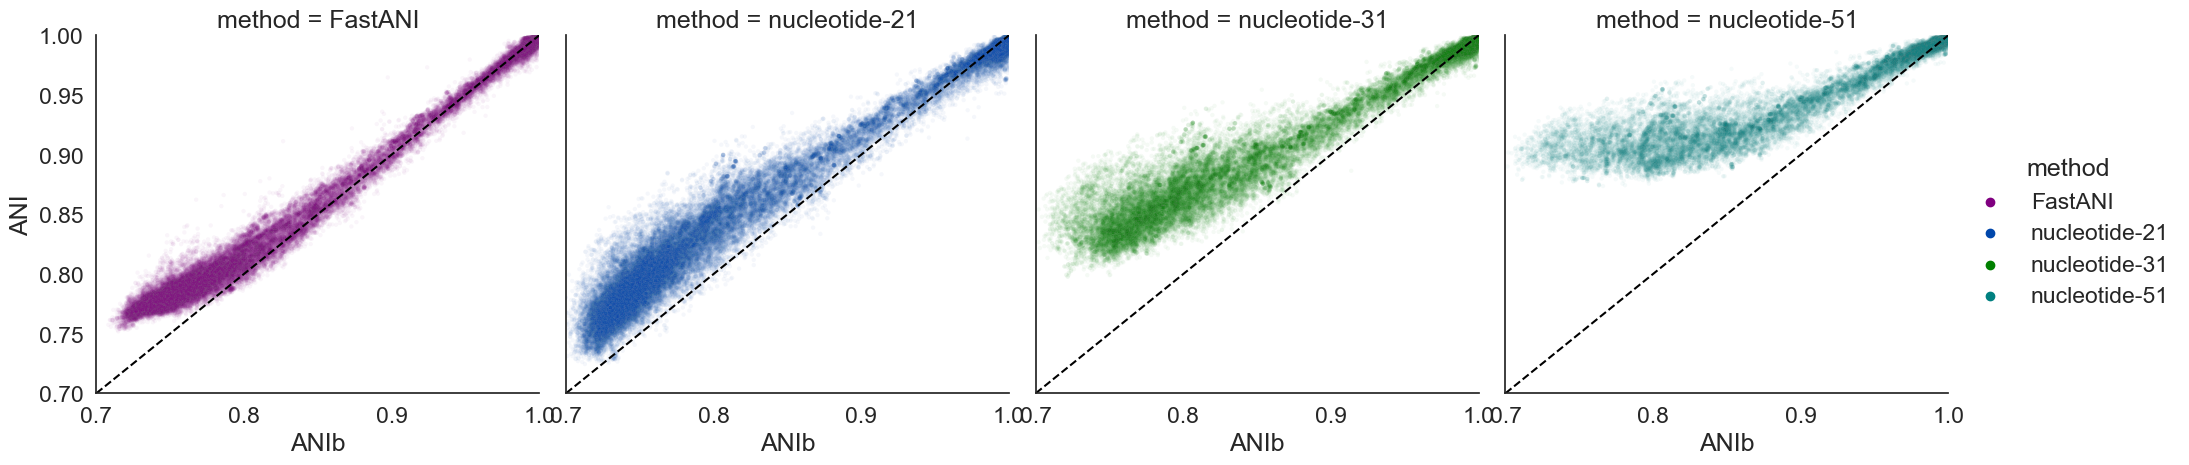

In [35]:
g = sns.relplot(data=ani[~ani["method"].isin(["pyani_anim", "pyani_anib"])], x = "ANIb", y="ANI", col="method", hue="method", alpha=0.04, s=10, palette=method_colors)
xlim = (0.7, 1)
g.set(xlim=xlim, ylim=xlim)
for ax in g.axes.flat:
    ax.plot(xlim, xlim, ls="--",color="black") #c=".3"

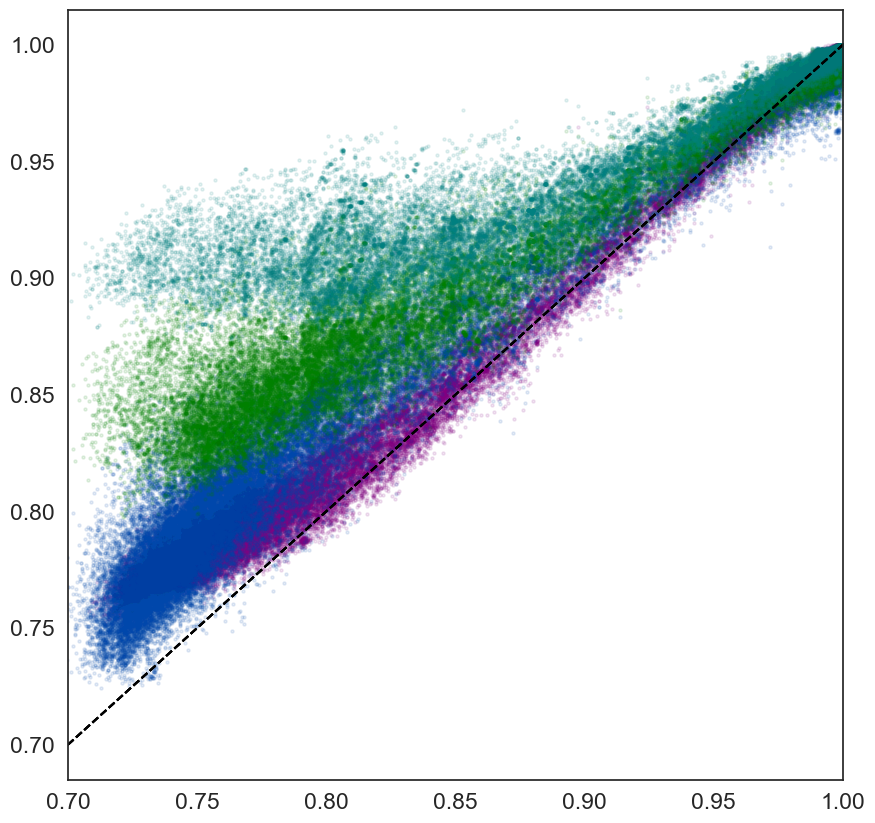

In [36]:


# two plots 1. ANI vs ANIb; 2. ANIb_cov vs ANI
sns.set_style("white")
#plt.rcParams["font.size"] = 25
# start the plot
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(121)
#ax2 = fig.add_subplot(122)
# to share y axis, do this instead
#fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(22,10))

# plotting params
alpha= 0.1# 0.04

#x_cols = ["ANIb", "ANIb_cov"]
y_col = ["ANI"]

axis_to_xcol = {ax1: "ANIb"}#, ax2: "ANIb_cov"}

for ax, x_col in axis_to_xcol.items():
    for method in methods:
        if method in ["pyani_anib", "pyani_anim"]:#, "nucleotide-31"]: #WHAT IS HAPPENING WITH ANIm!???? Looks very weird.
            continue #(no need to plot ANIb x ANIb)
        
        # subset dataframe to just this method
        df = ani[ani["method"] == method].dropna()
        #ax.scatter(df[x_col], df[y_col], alpha=alpha, marker='o', s=5,color=method_colors[method])
        ax.scatter(df[x_col], df["ANI"], alpha=alpha, marker='o', s=5,color=method_colors[method])
        if x_col == "ANIb":
            xlim = (0.7, 1)
            ax.set_xlim(xlim)
            ax.plot(xlim, xlim, ls="--",color="black") #c=".3"


        ##### do we want/need these?
        #slope, intercept, r_value, p_value, std_err = sp.stats.linregress(df[x_col],df["ANI"])
        #r_value is pearson correlation coefficient
        #predict_y = slope * df[x_col] + intercept
        # do we want R^2? if yes, get from sklearn r2_score using y_observed, y_predicted
        #r_squared = r2_score(df[y_col], predict_y)
        #label = labelD[var] + " " + ak_labels[ak] #param_labels[n]
        #line_label = f'{method}\ny={slope:.4f}x+{intercept:.3f}\nR2={r_squared:.3f}\nr={r_value:.3f}'





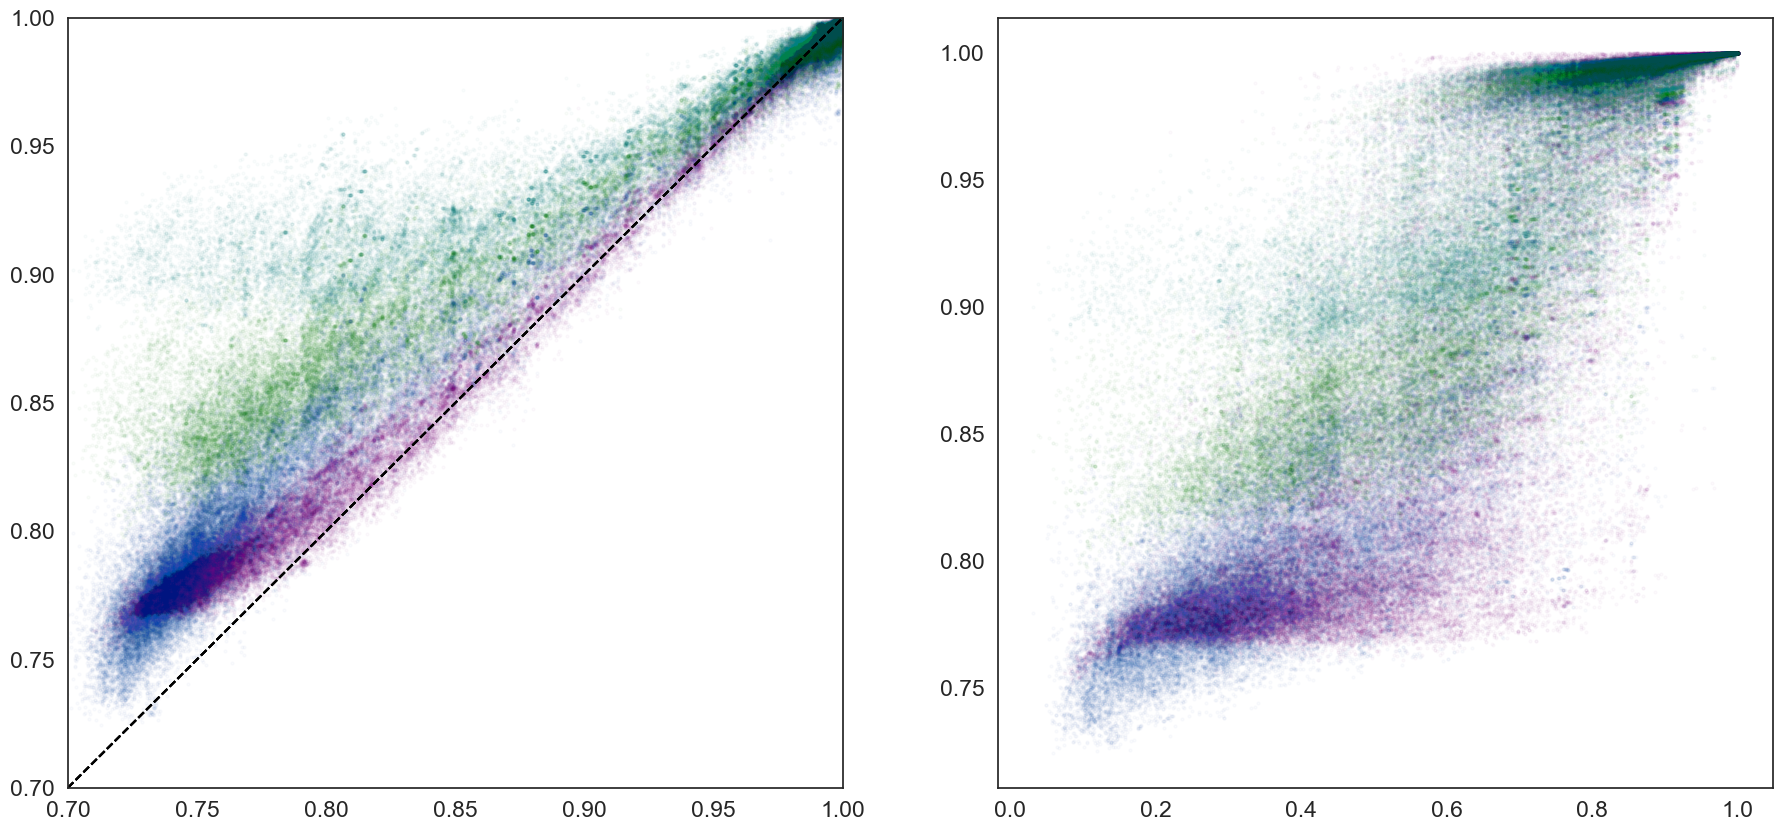

In [37]:


# two plots 1. ANI vs ANIb; 2. ANIb_cov vs ANI
sns.set_style("white")
#plt.rcParams["font.size"] = 25
# start the plot
fig = plt.figure(figsize=(22,10))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# to share y axis, do this instead
#fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(22,10))

# plotting params
alpha=0.02 # 0.05

#x_cols = ["ANIb", "ANIb_cov"]
y_col = ["ANI"]

axis_to_xcol = {ax1: "ANIb", ax2: "ANIb_cov"}

for ax, x_col in axis_to_xcol.items():
    for method in methods:
        if method in ["pyani_anib", "pyani_anim"]:#, "nucleotide-31"]: #WHAT IS HAPPENING WITH ANIm!???? Looks very weird.
            continue #(no need to plot ANIb x ANIb)
        
        # subset dataframe to just this method
        df = ani[ani["method"] == method].dropna()
        #ax.scatter(df[x_col], df[y_col], alpha=alpha, marker='o', s=5,color=method_colors[method])
        ax.scatter(df[x_col], df["ANI"], alpha=alpha, marker='o', s=5,color=method_colors[method])
        if x_col == "ANIb":
            xlim = (0.7, 1)
            ylim = (0.7, 1)
            #xlim = (0.99, 1)
            #ylim = (0.96, 1)
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.plot(xlim, xlim, ls="--",color="black") #c=".3"


        ##### do we want/need these?
        #slope, intercept, r_value, p_value, std_err = sp.stats.linregress(df[x_col],df["ANI"])
        #r_value is pearson correlation coefficient
        #predict_y = slope * df[x_col] + intercept
        # do we want R^2? if yes, get from sklearn r2_score using y_observed, y_predicted
        #r_squared = r2_score(df[y_col], predict_y)
        #label = labelD[var] + " " + ak_labels[ak] #param_labels[n]
        #line_label = f'{method}\ny={slope:.4f}x+{intercept:.3f}\nR2={r_squared:.3f}\nr={r_value:.3f}'





In [45]:
ani["ANIdiff"] = ani["ANI"] - ani["ANIb"]
ani

comparison_name lca_rank  \
0       GCF_002252245_x_GCF_018415725  species   
1       GCF_002252245_x_GCF_018415905  species   
2       GCF_002252245_x_GCF_018415875  species   
3       GCF_002252245_x_GCF_002252325  species   
4       GCF_002252245_x_GCF_018415665  species   
...                               ...      ...   
720601  GCA_016187745_x_GCA_018304445    genus   
720602  GCA_011334735_x_GCA_014361295    genus   
720603  GCA_019058315_x_GCA_013375355    genus   
720604  GCA_018302805_x_GCA_018302785    genus   
720605  GCA_013331595_x_GCA_018304285    genus   

                                lca_lineage      ANIb  ANIb_cov  \
0       s__Wohlfahrtiimonas chitiniclastica  0.980896  0.905852   
1       s__Wohlfahrtiimonas chitiniclastica  0.981019  0.910210   
2       s__Wohlfahrtiimonas chitiniclastica  0.979370  0.894288   
3       s__Wohlfahrtiimonas chitiniclastica  0.980128  0.916761   
4       s__Wohlfahrtiimonas chitiniclastica  0.980726  0.931576   
...                                     ...       ...       ...   
720601                          g__JACPJC01  0.875225  0.498841   
720602                          g__JACIVX01  0.883671  0.730546   
720603                          g__JABXJV01  0.846342  0.525580   
720604                          g__JAGVZF01  0.751491  0.356937   
720605                          g__UBA10210  0.745205  0.202488   

               method       ANI  cov_or_containment   ANIdiff  
0          pyani_anib  0.980896            0.905852  0.000000  
1          pyani_anib  0.981019            0.910210  0.000000  
2          pyani_anib  0.979370            0.894288  0.000000  
3          pyani_anib  0.980128            0.916761  0.000000  
4          pyani_anib  0.980726            0.931576  0.000000  
...               ...       ...                 ...       ...  
720601  nucleotide-51  0.920882            0.015235  0.045657  
720602  nucleotide-51  0.913603            0.010127  0.029932  
720603  nucleotide-51  0.887925            0.002349  0.041584  
720604  nucleotide-51  0.916807            0.011930  0.165316  
720605  nucleotide-51  0.930169            0.025807  0.184964  

[720606 rows x 9 columns]

In [56]:
ani90 = ani[(ani["ANIb"] >= 0.9) & (ani["ANIb"] <= 0.9001) & (~ani["method"].isin(["pyani_anib", "pyani_anim"]))]
ani90

comparison_name lca_rank              lca_lineage  \
468393  GCF_002300425_x_GCF_000166695    genus  g__Caldicellulosiruptor   
468736  GCF_003001715_x_GCF_000166695    genus  g__Caldicellulosiruptor   
487041  GCA_003500865_x_GCA_009392675    genus              g__UBA11996   
498359  GCF_000018605_x_GCA_001508055    genus             g__Petrotoga   
501863  GCA_007125675_x_GCA_003554685    genus            g__T1SED10-84   
515436  GCA_007127695_x_GCA_007122185    genus                g__SKNL01   
521843  GCA_009843115_x_GCA_011523635    genus                g__VXMP01   
531392  GCA_000698185_x_GCA_012970285    genus        g__Geomicrobium_A   
550395  GCF_002300425_x_GCF_000166695    genus  g__Caldicellulosiruptor   
550751  GCF_003001715_x_GCF_000166695    genus  g__Caldicellulosiruptor   
579624  GCF_000018605_x_GCA_001508055    genus             g__Petrotoga   
582719  GCA_007125675_x_GCA_003554685    genus            g__T1SED10-84   
600982  GCA_009843115_x_GCA_011523635    genus                g__VXMP01   
609835  GCA_000698185_x_GCA_012970285    genus        g__Geomicrobium_A   
627822  GCF_002300425_x_GCF_000166695    genus  g__Caldicellulosiruptor   
628173  GCF_003001715_x_GCF_000166695    genus  g__Caldicellulosiruptor   
642955  GCA_003500865_x_GCA_009392675    genus              g__UBA11996   
649934  GCF_000018605_x_GCA_001508055    genus             g__Petrotoga   
652500  GCA_007125675_x_GCA_003554685    genus            g__T1SED10-84   
664125  GCA_009843115_x_GCA_011523635    genus                g__VXMP01   
670044  GCA_000698185_x_GCA_012970285    genus        g__Geomicrobium_A   
681277  GCF_002300425_x_GCF_000166695    genus  g__Caldicellulosiruptor   
681634  GCF_003001715_x_GCF_000166695    genus  g__Caldicellulosiruptor   
694086  GCA_003500865_x_GCA_009392675    genus              g__UBA11996   
699461  GCF_000018605_x_GCA_001508055    genus             g__Petrotoga   
701465  GCA_007125675_x_GCA_003554685    genus            g__T1SED10-84   
709707  GCA_009843115_x_GCA_011523635    genus                g__VXMP01   
713831  GCA_000698185_x_GCA_012970285    genus        g__Geomicrobium_A   

            ANIb  ANIb_cov         method       ANI  cov_or_containment  \
468393  0.900092  0.685025        FastANI  0.907529            0.744762   
468736  0.900038  0.684962        FastANI  0.907688            0.743009   
487041  0.900044  0.631277        FastANI  0.893684            0.639375   
498359  0.900032  0.731991        FastANI  0.895498            0.750828   
501863  0.900051  0.512204        FastANI  0.896838            0.598040   
515436  0.900011  0.512844        FastANI  0.895354            0.560184   
521843  0.900034  0.658182        FastANI  0.903166            0.706891   
531392  0.900015  0.860593        FastANI  0.905779            0.873907   
550395  0.900092  0.685025  nucleotide-21  0.925055            0.194778   
550751  0.900038  0.684962  nucleotide-21  0.925049            0.194764   
579624  0.900032  0.731991  nucleotide-21  0.913323            0.149313   
582719  0.900051  0.512204  nucleotide-21  0.902841            0.117112   
600982  0.900034  0.658182  nucleotide-21  0.913985            0.152141   
609835  0.900015  0.860593  nucleotide-21  0.921648            0.180249   
627822  0.900092  0.685025  nucleotide-31  0.935990            0.128661   
628173  0.900038  0.684962  nucleotide-31  0.935820            0.127950   
642955  0.900044  0.631277  nucleotide-31  0.921702            0.079931   
649934  0.900032  0.731991  nucleotide-31  0.922760            0.082884   
652500  0.900051  0.512204  nucleotide-31  0.917560            0.069588   
664125  0.900034  0.658182  nucleotide-31  0.918358            0.071701   
670044  0.900015  0.860593  nucleotide-31  0.932537            0.114746   
681277  0.900092  0.685025  nucleotide-51  0.946300            0.059921   
681634  0.900038  0.684962  nucleotide-51  0.946224            0.059681   
694086  0.900044  0.631277  nucleotide-51  0.9

In [57]:
ani90[ani90["method"] == "nucleotide-21"]

comparison_name lca_rank              lca_lineage  \
550395  GCF_002300425_x_GCF_000166695    genus  g__Caldicellulosiruptor   
550751  GCF_003001715_x_GCF_000166695    genus  g__Caldicellulosiruptor   
579624  GCF_000018605_x_GCA_001508055    genus             g__Petrotoga   
582719  GCA_007125675_x_GCA_003554685    genus            g__T1SED10-84   
600982  GCA_009843115_x_GCA_011523635    genus                g__VXMP01   
609835  GCA_000698185_x_GCA_012970285    genus        g__Geomicrobium_A   

            ANIb  ANIb_cov         method       ANI  cov_or_containment  \
550395  0.900092  0.685025  nucleotide-21  0.925055            0.194778   
550751  0.900038  0.684962  nucleotide-21  0.925049            0.194764   
579624  0.900032  0.731991  nucleotide-21  0.913323            0.149313   
582719  0.900051  0.512204  nucleotide-21  0.902841            0.117112   
600982  0.900034  0.658182  nucleotide-21  0.913985            0.152141   
609835  0.900015  0.860593  nucleotide-21  0.921648            0.180249   

         ANIdiff  
550395  0.024963  
550751  0.025011  
579624  0.013291  
582719  0.002790  
600982  0.013952  
609835  0.021633

In [61]:
ani80 = ani[(ani["ANIb"] >= 0.8) & (ani["ANIb"] <= 0.80005) & (~ani["method"].isin(["pyani_anib", "pyani_anim"]))]
ani80

comparison_name lca_rank                lca_lineage  \
469613  GCF_900102605_x_GCF_900156285    genus           g__Halanaerobium   
481768  GCA_001778615_x_GCA_001001285    genus              g__GWA1-44-29   
483346  GCA_002441365_x_GCF_008630935    genus  g__Thermodesulfobacterium   
500410  GCA_009992775_x_GCA_003527405   family                  f__34-128   
520979  GCF_002205395_x_GCF_001548035    genus        g__Sulfurospirillum   
521064  GCA_002783685_x_GCA_018814245    genus            g__CG2-30-40-21   
521082  GCA_002772295_x_GCA_018814245    genus            g__CG2-30-40-21   
527187  GCA_016707895_x_GCA_018062915    genus                 g__UBA2376   
527262  GCA_018055015_x_GCA_016717005    genus                 g__UBA2376   
530489  GCF_004331335_x_GCF_004342085    genus               g__Kribbella   
530560  GCF_004331435_x_GCF_004342085    genus               g__Kribbella   
530593  GCF_004366075_x_GCF_004340265    genus               g__Kribbella   
542858  GCA_002869015_x_GCA_002869005    genus                   g__BM512   
543069  GCA_016208255_x_GCA_001797675    genus            g__RBG-13-43-22   
547411  GCF_000190315_x_GCA_001316005    genus            g__Vulcanisaeta   
551648  GCF_900102605_x_GCF_900156285    genus           g__Halanaerobium   
564186  GCA_001778615_x_GCA_001001285    genus              g__GWA1-44-29   
565630  GCA_002441365_x_GCF_008630935    genus  g__Thermodesulfobacterium   
581366  GCA_009992775_x_GCA_003527405   family                  f__34-128   
600243  GCF_002205395_x_GCF_001548035    genus        g__Sulfurospirillum   
600318  GCA_002783685_x_GCA_018814245    genus            g__CG2-30-40-21   
600340  GCA_002772295_x_GCA_018814245    genus            g__CG2-30-40-21   
621414  GCA_002869015_x_GCA_002869005    genus                   g__BM512   
621625  GCA_016208255_x_GCA_001797675    genus            g__RBG-13-43-22   
625362  GCF_000190315_x_GCA_001316005    genus            g__Vulcanisaeta   
629062  GCF_900102605_x_GCF_900156285    genus           g__Halanaerobium   
663671  GCF_002205395_x_GCF_001548035    genus        g__Sulfurospirillum   
663709  GCA_002783685_x_GCA_018814245    genus            g__CG2-30-40-21   
663727  GCA_002772295_x_GCA_018814245    genus            g__CG2-30-40-21   
667446  GCA_016707895_x_GCA_018062915    genus                 g__UBA2376   
667487  GCA_018055015_x_GCA_016717005    genus                 g__UBA2376   
669249  GCF_004331335_x_GCF_004342085    genus               g__Kribbella   
669320  GCF_004331435_x_GCF_004342085    genus               g__Kribbella   
669344  GCF_004366075_x_GCF_004340265    genus               g__Kribbella   
676175  GCA_002869015_x_GCA_002869005    genus                   g__BM512   
676293  GCA_016208255_x_GCA_001797675    genus            g__RBG-13-43-22   
679311  GCF_000190315_x_GCA_001316005    genus            g__Vulcanisaeta   
682430  GCF_900102605_x_GCF_900156285    genus           g__Halanaerobium   
713071  GCF_004331335_x_GCF_004342085    genus               g__Kribbella   
713142  GCF_004331435_x_GCF_004342085    genus               g__Kribbella   
713166  GCF_004366075_x_GCF_004340265    genus               g__Kribbella   

            ANIb  ANIb_cov         method       ANI  cov_or_containment  \
469613  0.800029  0.529541        FastANI  0.814376            0.514254   
481768  0.800014  0.438765        FastANI  0.825135            0.575353   
483346  0.800010  0.691235        FastANI  0.800489            0.593664   
500410  0.800039  0.327036        FastANI  0.794619            0.388638   
520979  0.800046  0.702713        FastANI  0.809650            0.625063   
521064  0.800044  0.322967        FastANI  0.801716            0.511625   
521082  0.800015  0.314137        FastANI  0.802044            0.518139   
527187  0.800043  0.473683        FastANI  0.831293            0.622231   
527262  0.800043  0.464893        FastANI  0.829005            0.626987   
530489  0.800018  0.425960        Fas

In [62]:
ani80[ani80["method"] == "nucleotide-21"]

comparison_name lca_rank                lca_lineage  \
551648  GCF_900102605_x_GCF_900156285    genus           g__Halanaerobium   
564186  GCA_001778615_x_GCA_001001285    genus              g__GWA1-44-29   
565630  GCA_002441365_x_GCF_008630935    genus  g__Thermodesulfobacterium   
581366  GCA_009992775_x_GCA_003527405   family                  f__34-128   
600243  GCF_002205395_x_GCF_001548035    genus        g__Sulfurospirillum   
600318  GCA_002783685_x_GCA_018814245    genus            g__CG2-30-40-21   
600340  GCA_002772295_x_GCA_018814245    genus            g__CG2-30-40-21   
621414  GCA_002869015_x_GCA_002869005    genus                   g__BM512   
621625  GCA_016208255_x_GCA_001797675    genus            g__RBG-13-43-22   
625362  GCF_000190315_x_GCA_001316005    genus            g__Vulcanisaeta   

            ANIb  ANIb_cov         method       ANI  cov_or_containment  \
551648  0.800029  0.529541  nucleotide-21  0.857944            0.040078   
564186  0.800014  0.438765  nucleotide-21  0.835552            0.023102   
565630  0.800010  0.691235  nucleotide-21  0.825772            0.018361   
581366  0.800039  0.327036  nucleotide-21  0.807705            0.011280   
600243  0.800046  0.702713  nucleotide-21  0.829945            0.019983   
600318  0.800044  0.322967  nucleotide-21  0.832080            0.021306   
600340  0.800015  0.314137  nucleotide-21  0.834447            0.022579   
621414  0.800020  0.868426  nucleotide-21  0.845310            0.029337   
621625  0.800040  0.287186  nucleotide-21  0.810080            0.012633   
625362  0.800045  0.715435  nucleotide-21  0.831932            0.020992   

         ANIdiff  
551648  0.057915  
564186  0.035538  
565630  0.025763  
581366  0.007666  
600243  0.029899  
600318  0.032036  
600340  0.034433  
621414  0.045290  
621625  0.010040  
625362  0.031887

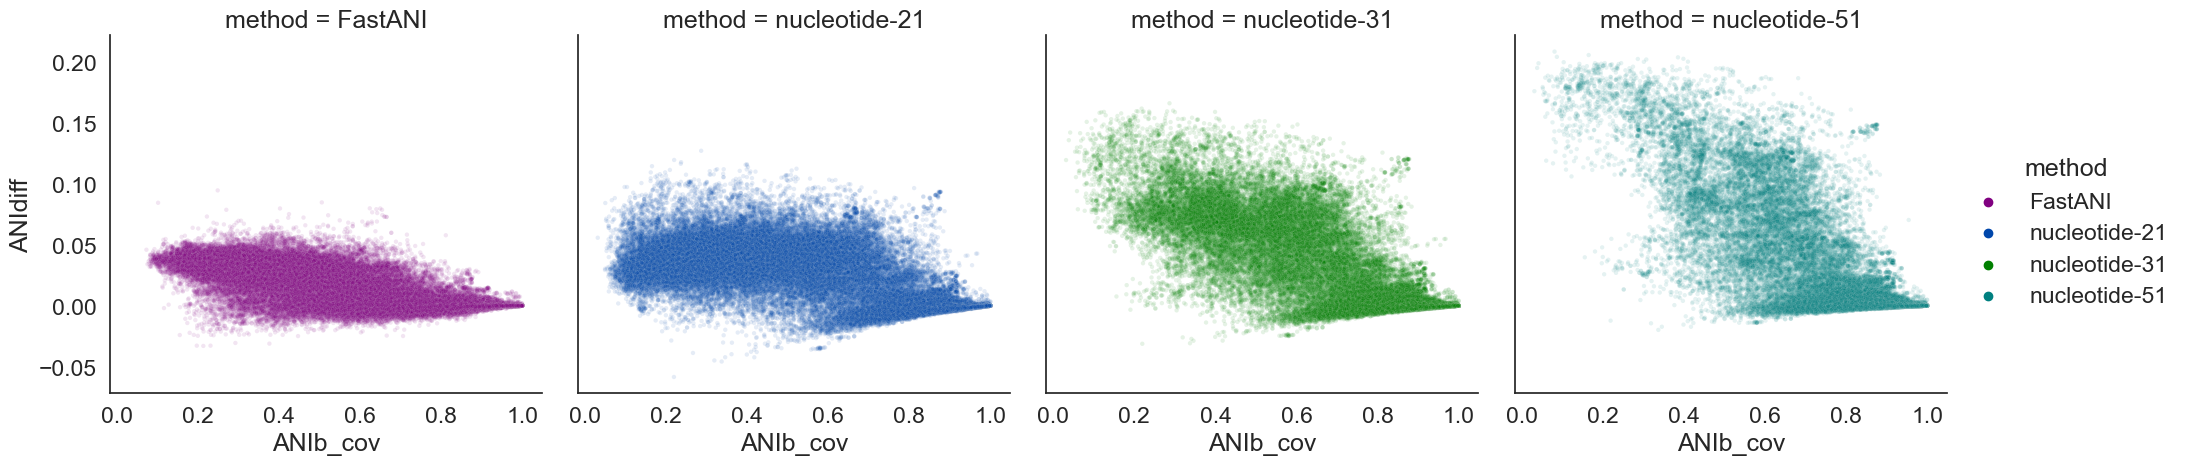

In [64]:
g = sns.relplot(data=ani[~ani["method"].isin(["pyani_anim", "pyani_anib"])], x = "ANIb_cov", y="ANIdiff", col="method", hue="method", alpha=0.1, s=10, palette=method_colors)
